<a href="https://colab.research.google.com/github/fernandafs/Projeto_PM/blob/main/Projeto_PM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto - Programação Matemática [2023.Q3]**

## Objetivos

Os objetivos deste projeto são:
* A familiarização com modelos de otimização linear para a construção de portfolios de ativos financeiros que ofereçam,
ao mesmo tempo, “bons” retornos ao capital inicial investido e uma “certa” proteção ao risco inerente envolvido em
tais operações;
* A familiarização com a linguagem de modelagem AMPL e sua utilização via Python no ambiente Colab da Google;
* A experimentação/solução dos modelos com dados reais (obtidos da plataforma Yahoo Finance) via solvers de
otimização linear;
* Uma ligeira análise dos resultados devolvidos pelos solvers.

Referência técnica: https://mo-book.ampl.com/notebooks/02/mad-portfolio-optimization.html

Referência teórica: https://www.andrew.cmu.edu/user/gc0v/webpub/book.pdf

## EQUIPE

**Nome:** Fernanda Felix da Silva

**RA:** 11201921613

**Nome:**

**RA:**

**Nome:**

**RA:**

## Configurações Iniciais

In [55]:
# install dependencies and select solver
%pip install -q amplpy numpy matplotlib scikit-learn yfinance

SOLVER = "highs"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.2 MB/s eta 0:00:00
Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://colab.ampl.com).


In [ ]:
# instalação do yahoo finance para busca das informações das ações escolhidas
%pip install yfinance --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 847.9 kB/s eta 0:00:00


In [52]:
# Bibliotecas importadas
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import datetime as datetime
import yfinance as yf
from scipy.optimize import minimize
import datetime as dt

### 1. Escolha 30 ações de empresas brasileiras e execute os códigos disponíveis para diferentes valores mínimos requeridos de retorno de portfolio e diferentes períodos de tempo. Reporte diferenças significativas, caso existam.

**Parte 1.a.** Listagem das 30 ações brasileiras e criação do gráfico de histórico de preços - Gráfico ajustado e gráfico com escala.

obs: Para a variação de períodos de tempo e valores mínimos futuramente, foi feito o gráfico para o período de 1 ano, 2 anos e 3 anos.

[*********************100%%**********************]  30 of 30 completed
[*********************100%%**********************]  30 of 30 completed
[*********************100%%**********************]  30 of 30 completed


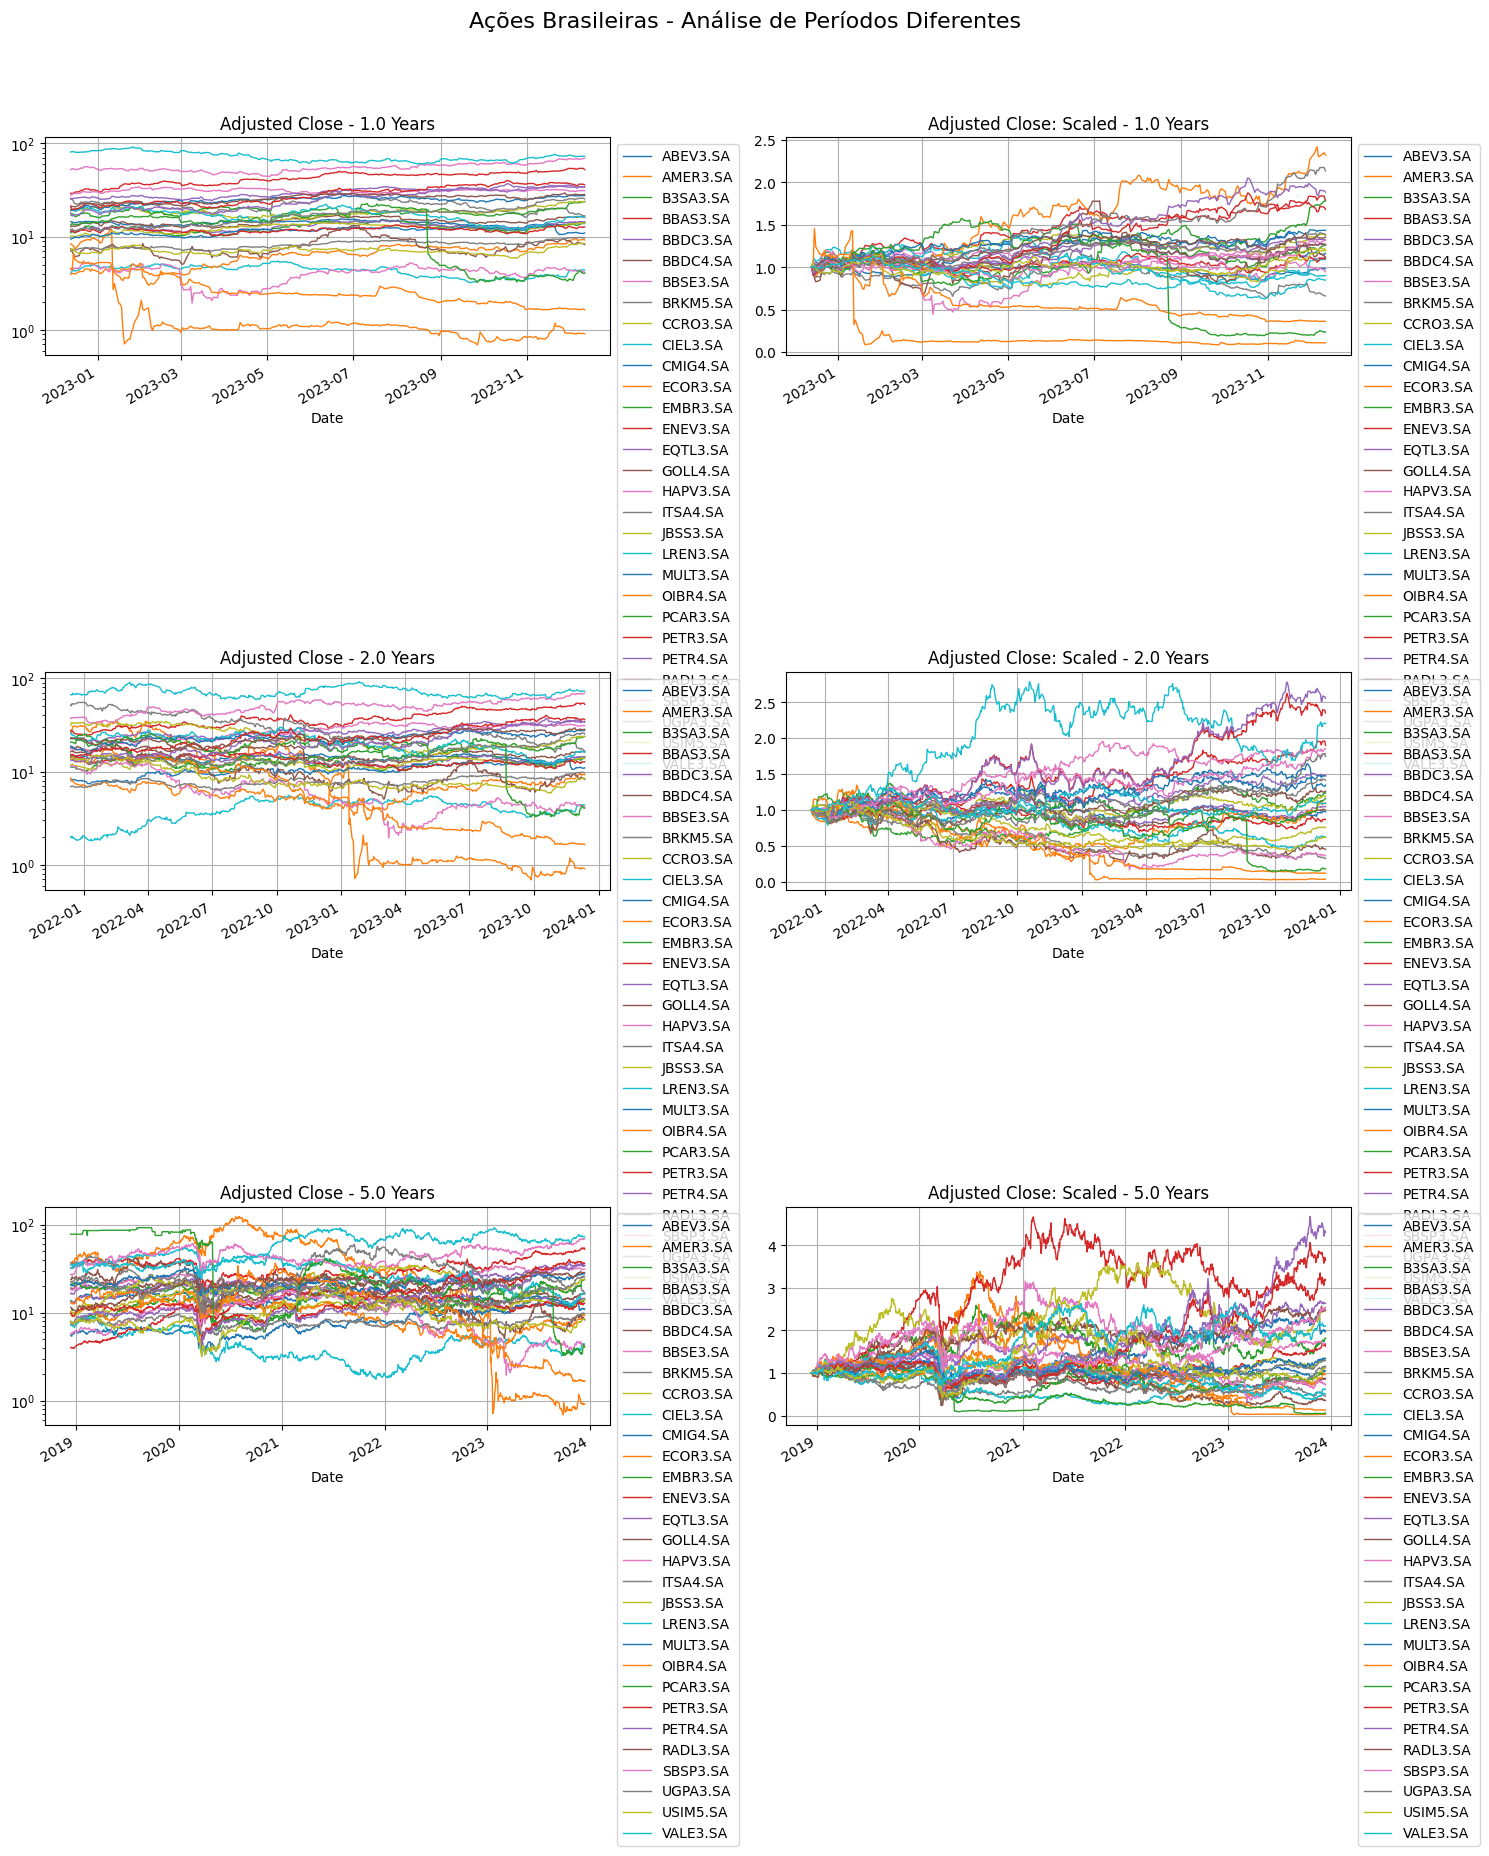

In [77]:
# list de 30 ações brasileiras (códigos)
tickers = [
    "RADL3.SA",	#Raia Drogasil S.A.
    "ENEV3.SA", #ENEVA
    "GOLL4.SA", #GOL Linhas aéreas
    "MULT3.SA",	#Multiplan Empreendimentos Imobiliários S.A.
    "JBSS3.SA",	#JBS
    "BBAS3.SA",	#Banco do Brasil S.A.
    "UGPA3.SA",	#Ultrapar Participações S.A.
    "PETR4.SA",	#Petróleo Brasileiro S.A. - Petrobras
    "USIM5.SA",	#Usinas Siderúrgicas de Minas Gerais S.A.
    "OIBR4.SA",	#Oi S.A.
    "EQTL3.SA",	#Equatorial Energia S.A.
    "BBDC4.SA",	#Banco Bradesco S.A.
    "ITSA4.SA",	#Itaúsa S.A.
    "B3SA3.SA", #B3
    "CCRO3.SA",	#CCR S.A.
    "BBDC3.SA",	#Banco Bradesco S.A.
    "ECOR3.SA",	#EcoRodovias Infraestrutura e Logística S.A.
    "CIEL3.SA", #CIELO
    "PCAR3.SA",	#Pão de açucar
    "CMIG4.SA",	#Companhia Energética de Minas Gerais - CEMIG
    "VALE3.SA", #VALE
    "PETR3.SA",	#Petróleo Brasileiro S.A. - Petrobras
    "BBSE3.SA",	#BB Seguridade Participações S.A.
    "SBSP3.SA",	#Companhia de Saneamento Básico do Estado de São Paulo - SABESP
    "AMER3.SA",	#Lojas Americanas
    "HAPV3.SA",	#Hapvida
    "LREN3.SA",	#Lojas Renner SA
    "ABEV3.SA",	#AMBEV
    "BRKM5.SA",	#Braskem S.A
    "EMBR3.SA"	#EMBRAER
]

def get_date_range(years):
    end_date = datetime.datetime.today().date()
    start_date = end_date - datetime.timedelta(round(years * 365))
    return start_date, end_date

# list number of years
periods = [1.0, 2.0, 3.0]

# Criar uma figura com subplots
fig, axs = plt.subplots(len(periods), 2, figsize=(15, len(periods) * 6))
fig.suptitle('Ações Brasileiras - Análise de Períodos Diferentes', fontsize=16)

for i, n_years in enumerate(periods):
    # Obter o intervalo de datas com base no número de anos
    start_date, end_date = get_date_range(n_years)

    assets = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]

    assets.fillna(method="bfill", inplace=True)
    assets.fillna(method="ffill", inplace=True)

    # Gráfico de linhas para preços ajustados
    assets.plot(logy=True, grid=True, lw=1, ax=axs[i, 0], title=f"Adjusted Close - {n_years} Years")
    axs[i, 0].legend(bbox_to_anchor=(1.0, 1.0))

    # Gráfico de linhas para preços ajustados escalados
    assets_scaled = assets.div(assets.iloc[0])
    assets_scaled.plot(grid=True, lw=1, ax=axs[i, 1], title=f"Adjusted Close: Scaled - {n_years} Years")
    axs[i, 1].legend(bbox_to_anchor=(1.0, 1.0))

# Ajustar o layout e mostrar os gráficos
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Parte 1.b.** Criação dos gráficos de retorno diários, considerando os valores do período de 1 ano, 2 anos e 3 anos.

[*********************100%%**********************]  30 of 30 completed


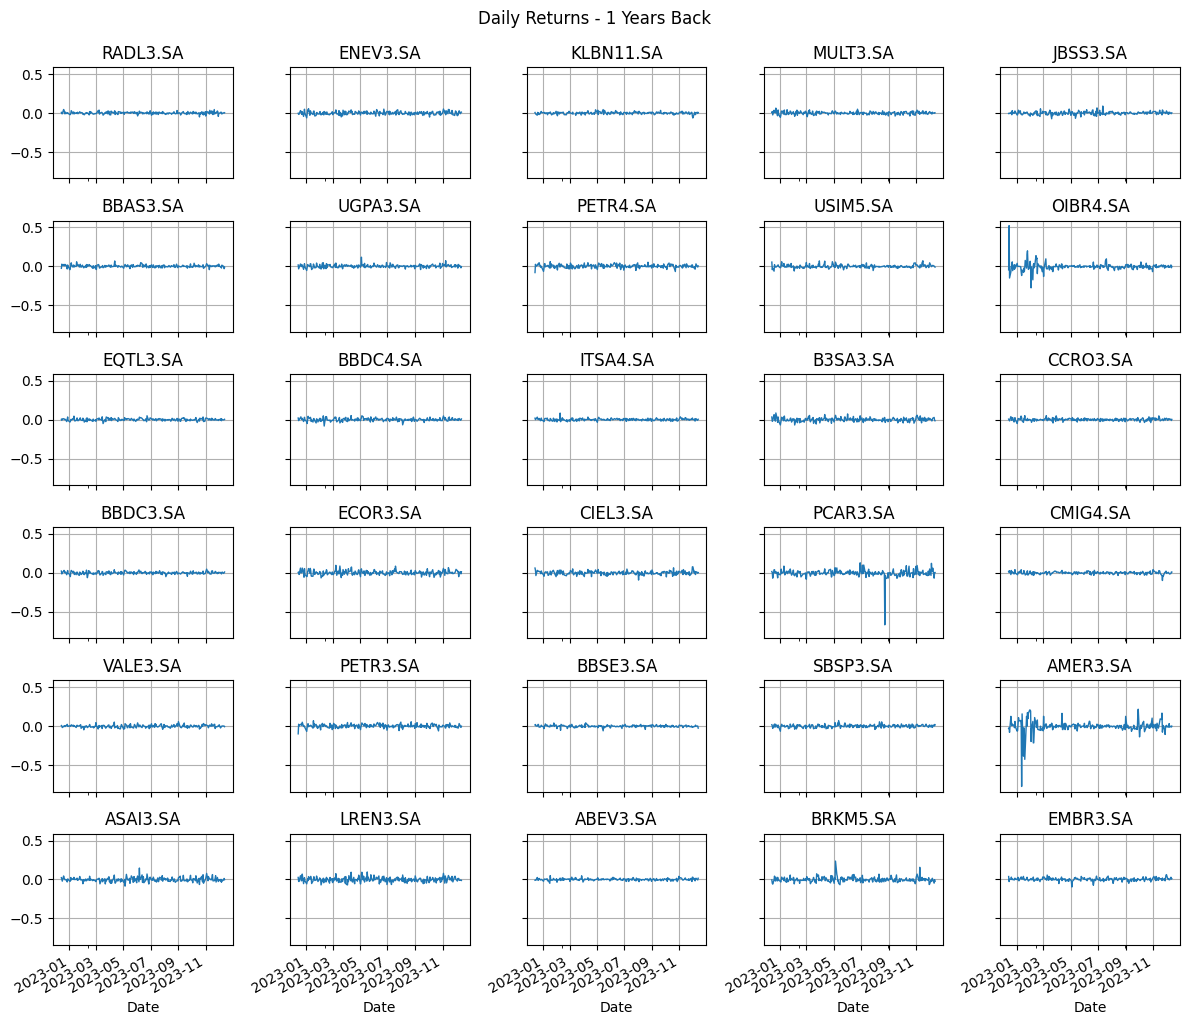

[*********************100%%**********************]  30 of 30 completed


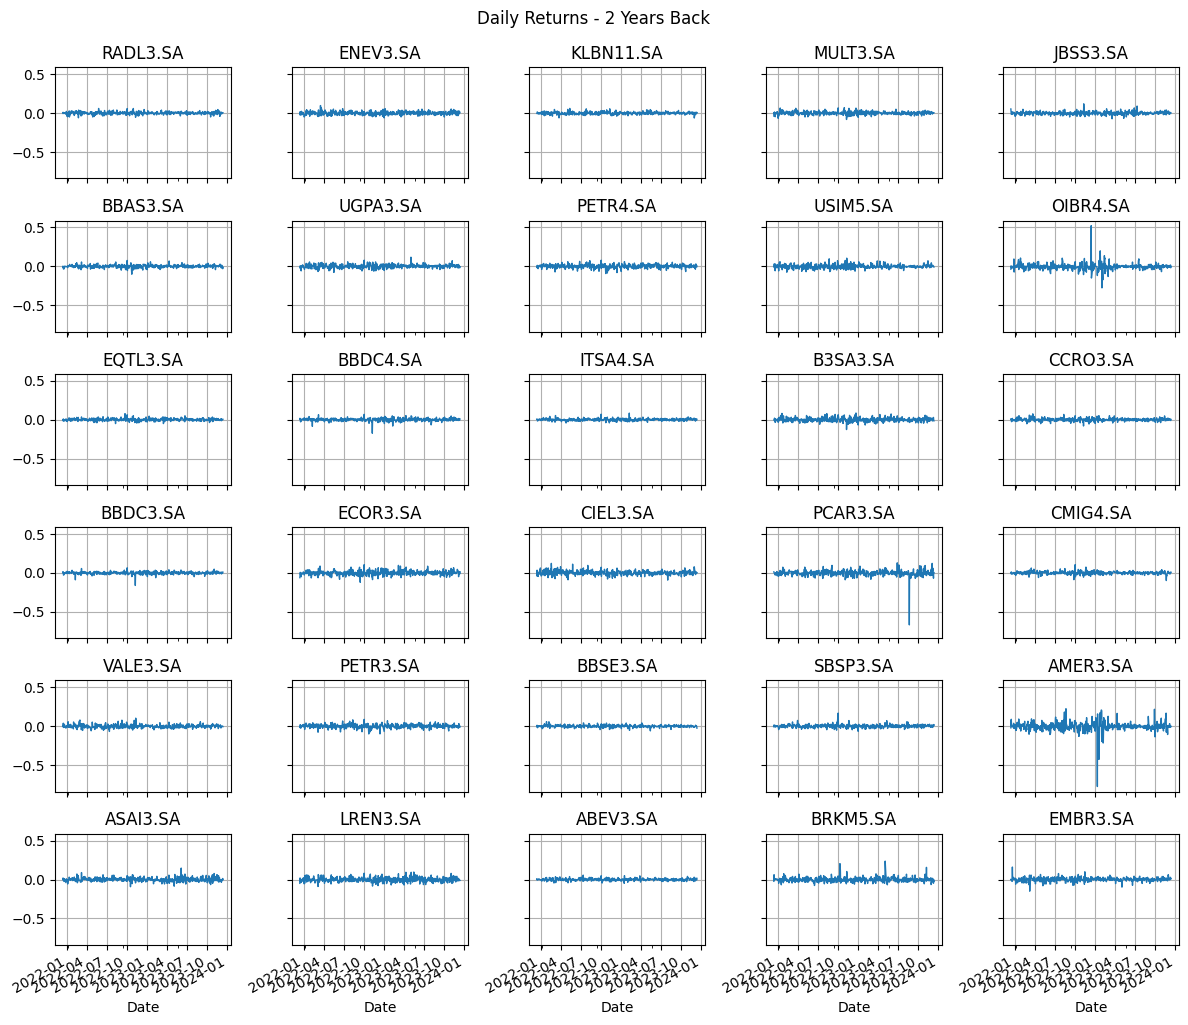

[*********************100%%**********************]  30 of 30 completed


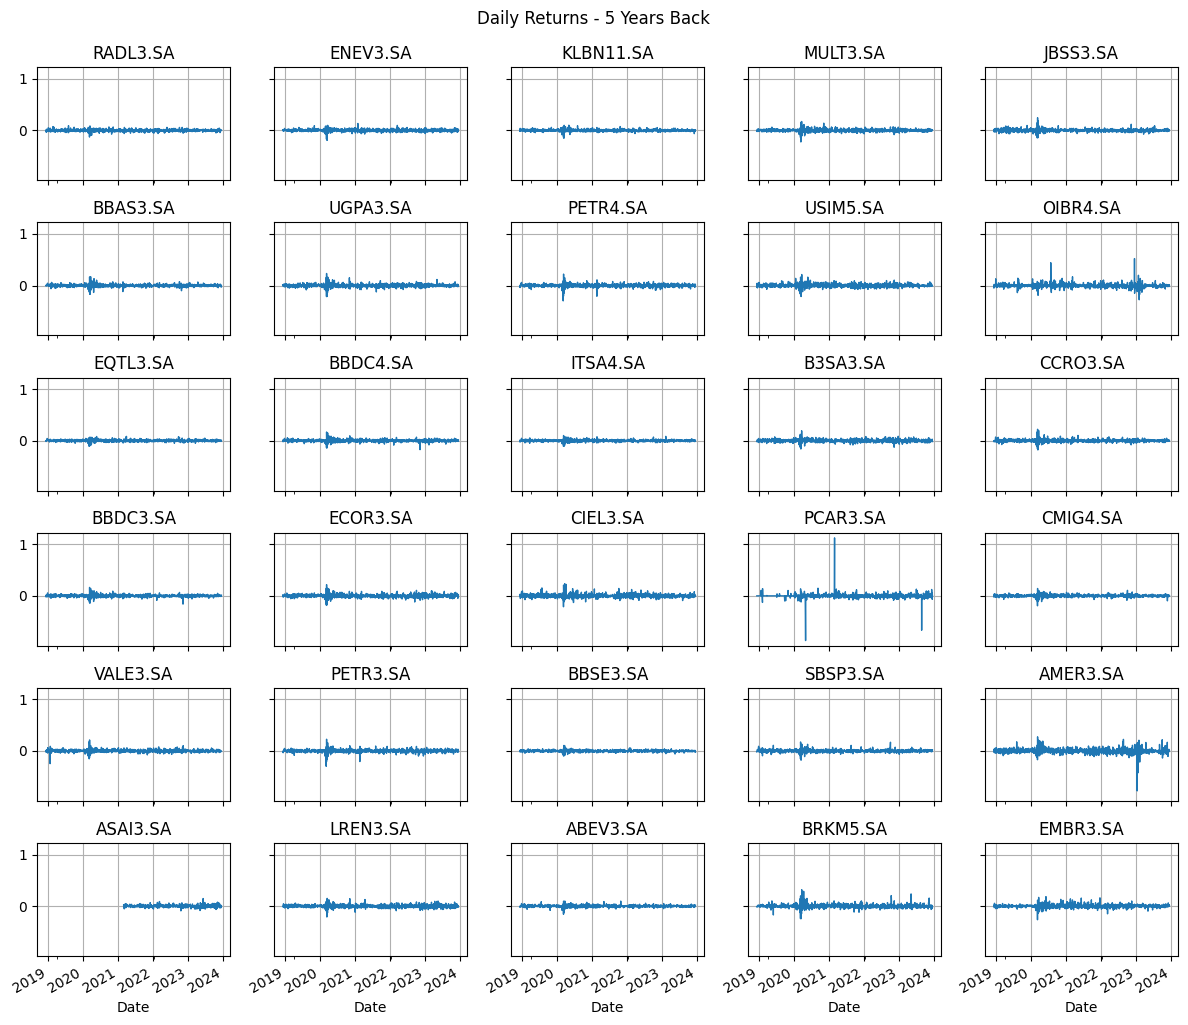

In [43]:
def plot_returns_n_years_back(tickers, num_years):
    # Obtém a data final
    end_date = pd.to_datetime('today')

    # Calcula a data inicial recuando o número de anos
    start_date = end_date - pd.DateOffset(years=num_years)

    # Baixa os dados usando yfinance
    assets = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]

    # Calcula os retornos diários
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]

    # Cria o subplot
    fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)

    # Plota os gráficos
    for a, s in zip(ax.flatten(), tickers):
        daily_returns[s].plot(ax=a, lw=1, title=s, grid=True)

    plt.tight_layout()
    plt.suptitle(f'Daily Returns - {num_years} Years Back', y=1.02)
    plt.show()

plot_returns_n_years_back(tickers, num_years=1)
plot_returns_n_years_back(tickers, num_years=2)
plot_returns_n_years_back(tickers, num_years=3)

**Parte 1.c.** Criação do gráfico de distribuição de retornos do príodo de 1 ano, 2 anos e 3 anos.

[*********************100%%**********************]  30 of 30 completed


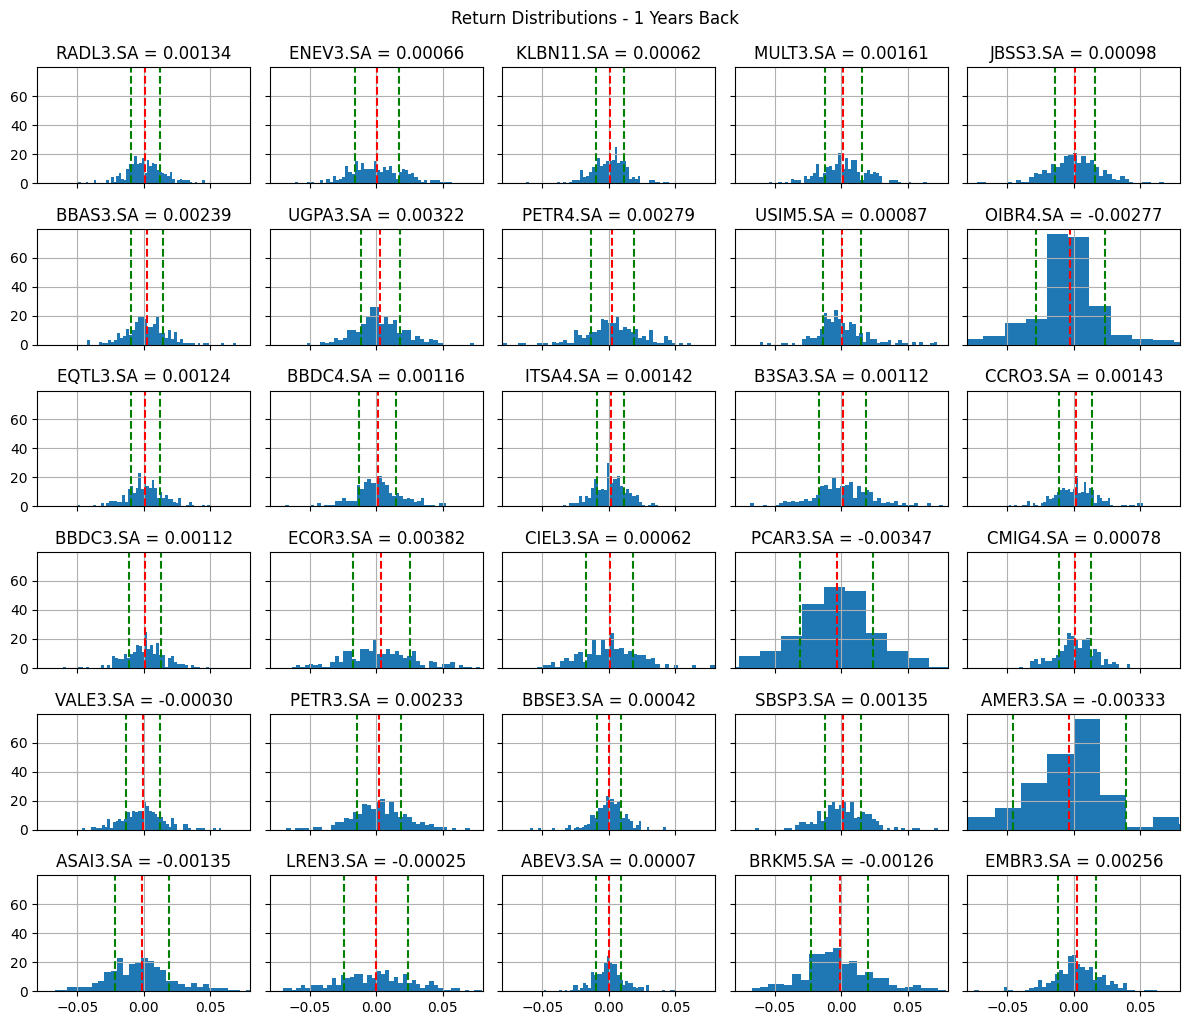

[*********************100%%**********************]  30 of 30 completed


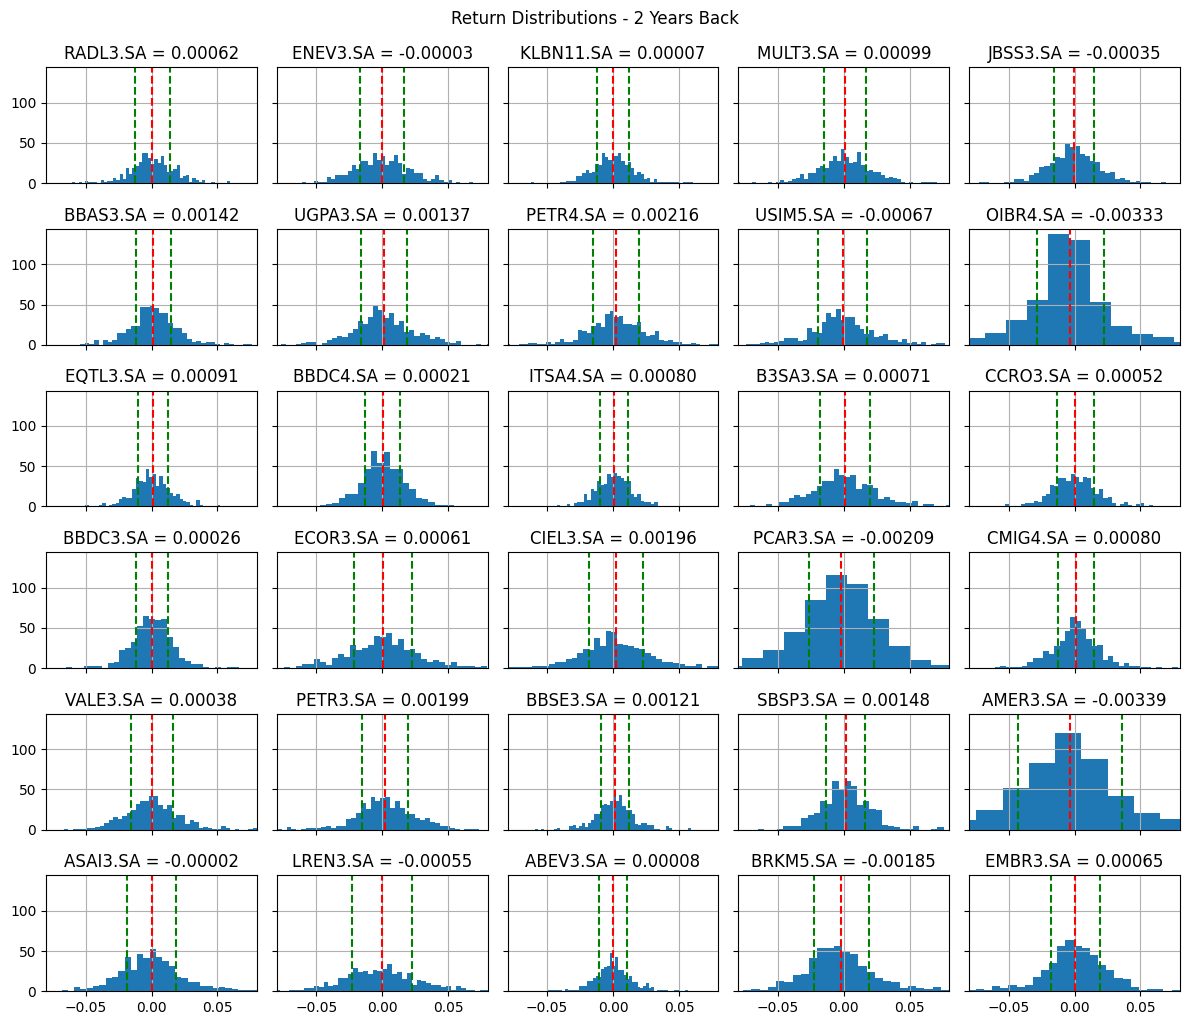

[*********************100%%**********************]  30 of 30 completed


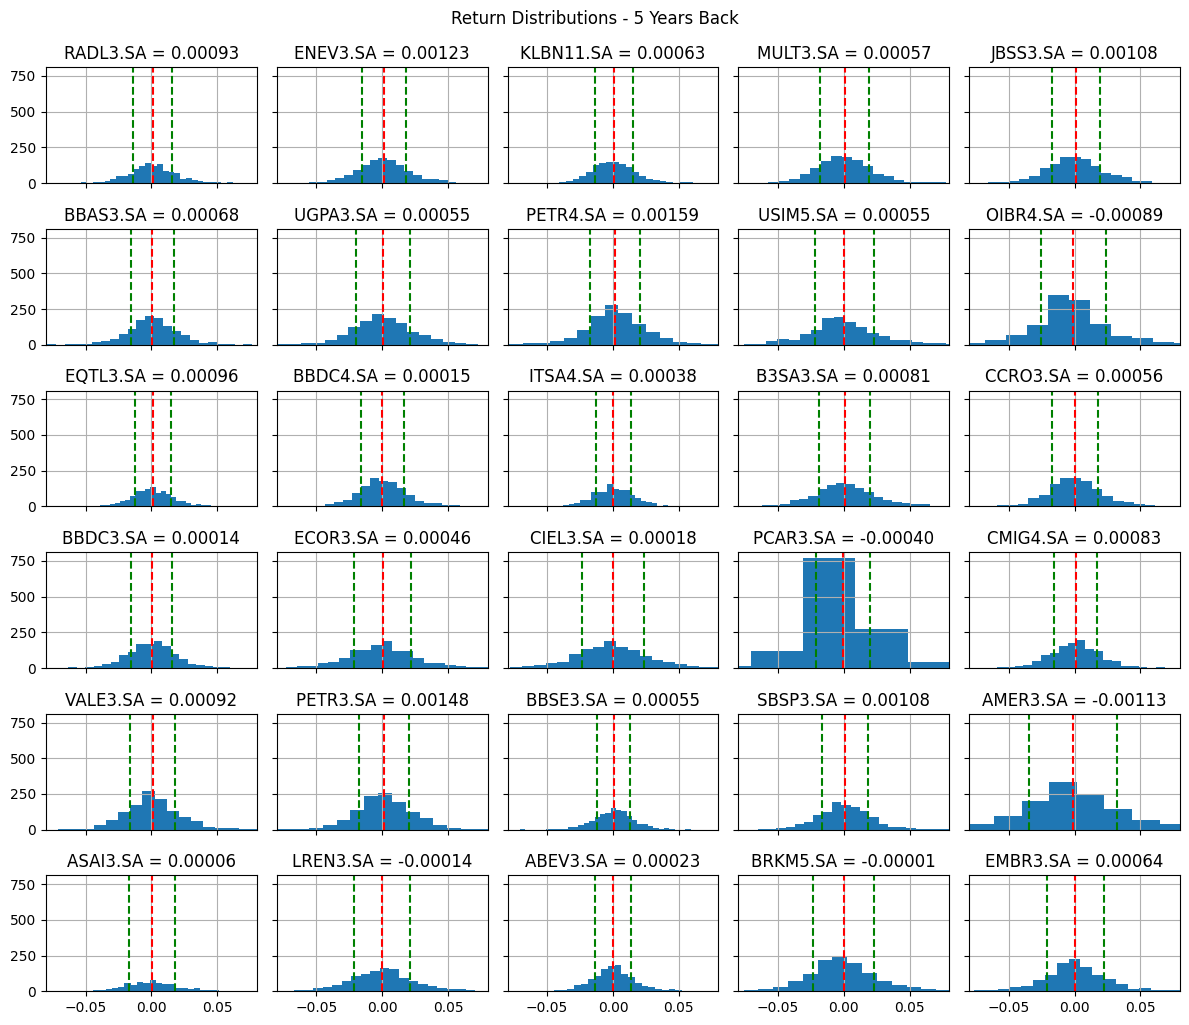

In [45]:
def plot_return_distributions_n_years_back(tickers, num_years):
    # Obtém a data final
    end_date = pd.to_datetime('today')

    # Calcula a data inicial recuando o número de anos
    start_date = end_date - pd.DateOffset(years=num_years)

    # Baixa os dados usando yfinance
    assets = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]

    # Calcula os retornos diários
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]

    # Cria o subplot
    fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)
    ax = ax.flatten()

    # Plota os histogramas e linhas de referência
    for a, s in zip(ax.flatten(), tickers):
        daily_returns[s].hist(ax=a, lw=1, grid=True, bins=50)
        mean_return = daily_returns[s].mean()
        mean_absolute_deviation = abs((daily_returns[s] - mean_return)).mean()
        a.set_title(f"{s} = {mean_return:0.5f}")
        a.set_xlim(-0.08, 0.08)
        a.axvline(mean_return, color="r", linestyle="--")
        a.axvline(mean_return + mean_absolute_deviation, color="g", linestyle="--")
        a.axvline(mean_return - mean_absolute_deviation, color="g", linestyle="--")

    plt.tight_layout()
    plt.suptitle(f'Return Distributions - {num_years} Years Back', y=1.02)
    plt.show()

plot_return_distributions_n_years_back(tickers, num_years=1)
plot_return_distributions_n_years_back(tickers, num_years=2)
plot_return_distributions_n_years_back(tickers, num_years=3)


**Parte 1.d** Gráfico mostrando a média de retorno e média de desvio absoluto nos retornos nos períodos de 1 ano, 2 anos e 3 anos.

[*********************100%%**********************]  30 of 30 completed


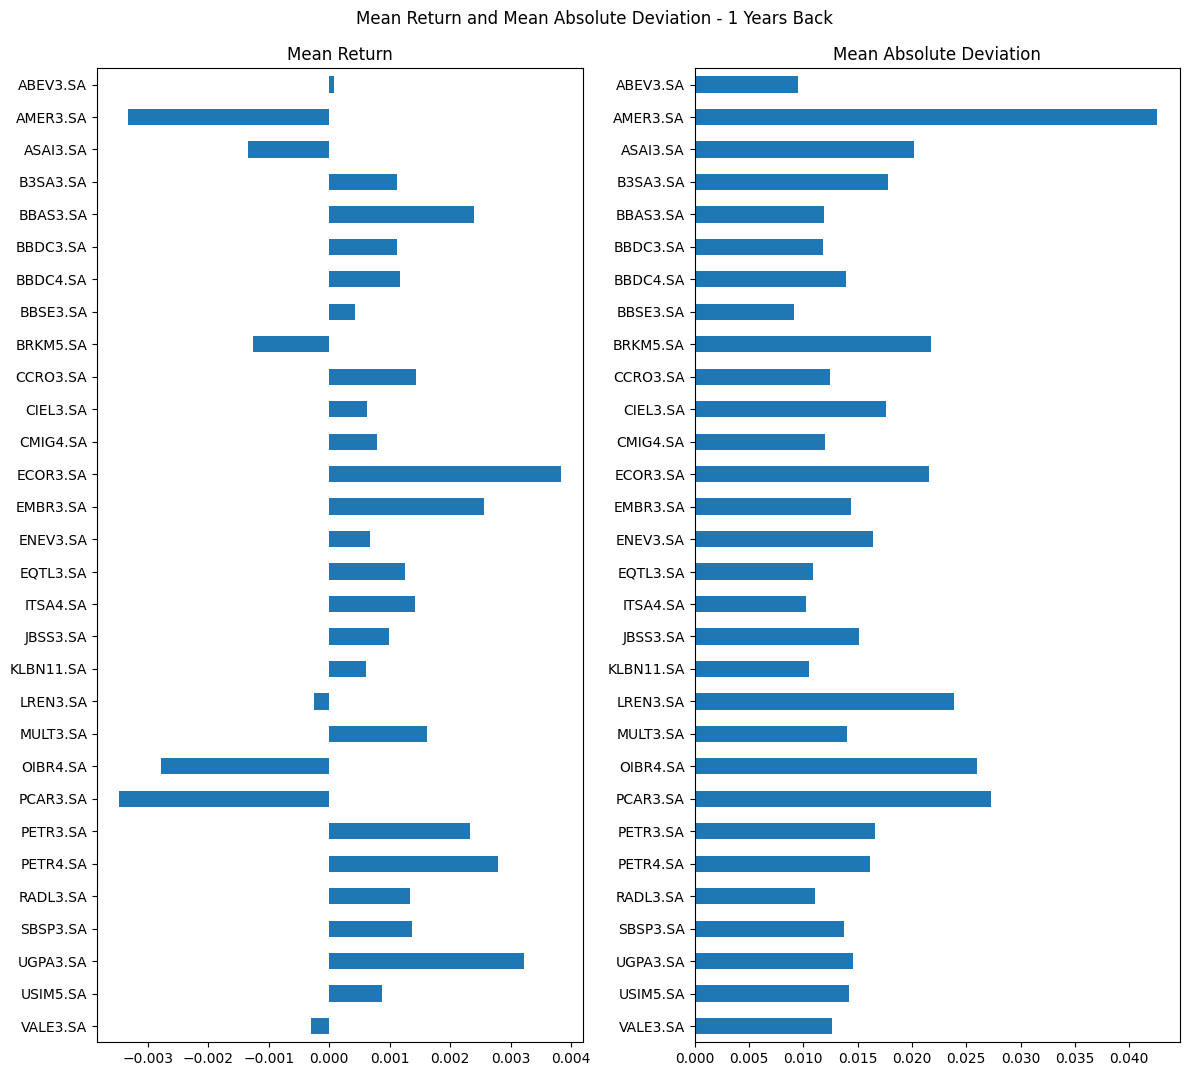

[*********************100%%**********************]  30 of 30 completed


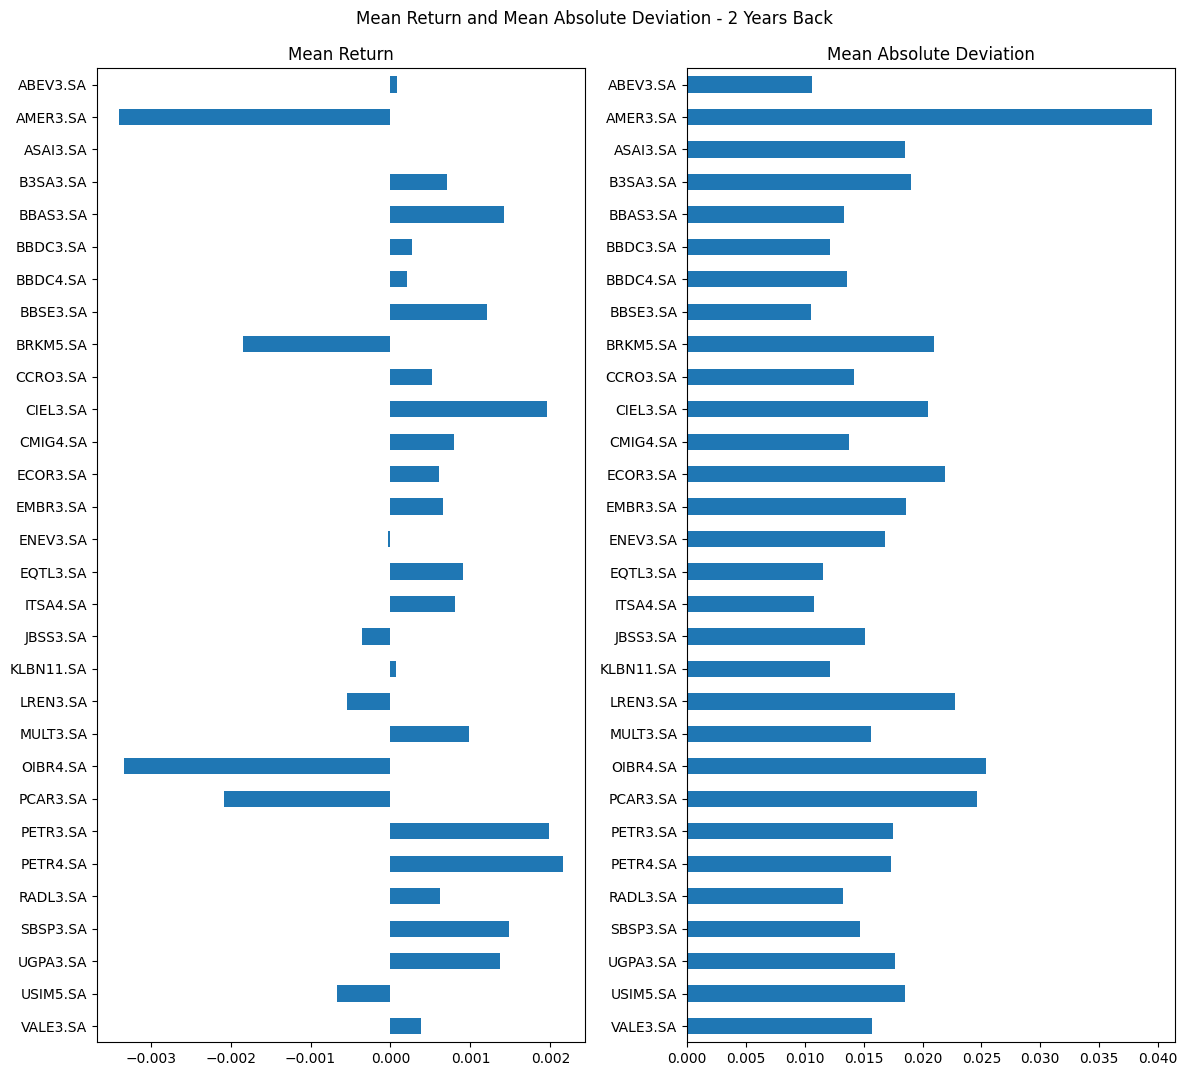

[*********************100%%**********************]  30 of 30 completed


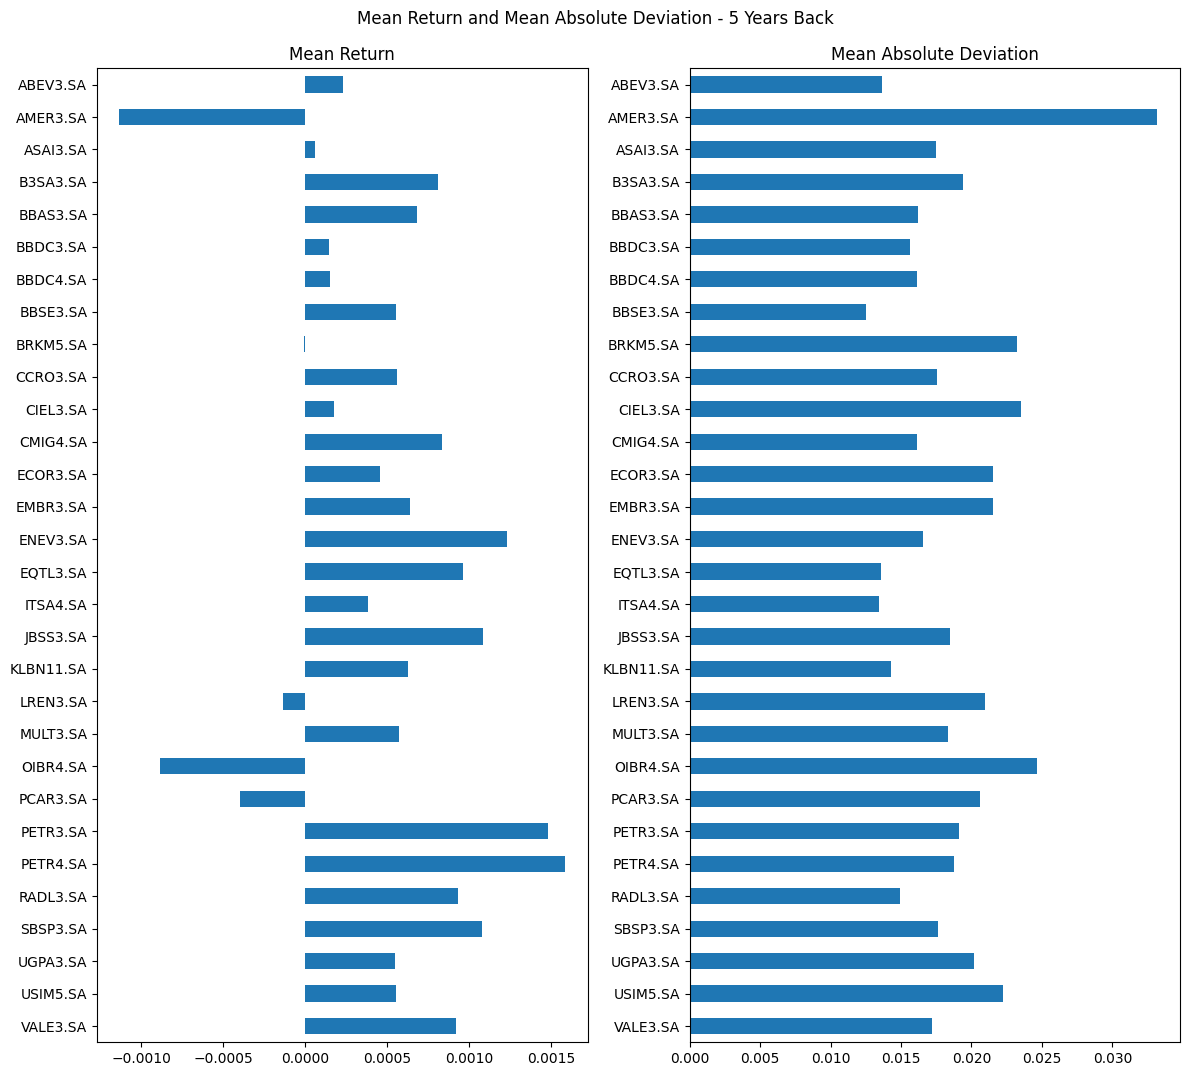

In [46]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

def plot_mean_return_deviation_n_years_back(tickers, num_years):
    # Obtém a data final
    end_date = pd.to_datetime('today')

    # Calcula a data inicial recuando o número de anos
    start_date = end_date - pd.DateOffset(years=num_years)

    # Baixa os dados usando yfinance
    assets = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]

    # Calcula os retornos diários
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]

    # Calcula o Mean Return e Mean Absolute Deviation
    mean_return = daily_returns.mean()
    mean_absolute_deviation = abs(daily_returns - mean_return).mean()

    # Cria o subplot
    fig, ax = plt.subplots(1, 2, figsize=(12, 0.35 * len(daily_returns.columns)))

    # Plota os gráficos de barras
    mean_return.plot(kind="barh", ax=ax[0], title="Mean Return")
    ax[0].invert_yaxis()

    mean_absolute_deviation.plot(kind="barh", ax=ax[1], title="Mean Absolute Deviation")
    ax[1].invert_yaxis()

    plt.tight_layout()
    plt.suptitle(f'Mean Return and Mean Absolute Deviation - {num_years} Years Back', y=1.02)
    plt.show()

plot_mean_return_deviation_n_years_back(tickers, num_years=1)
plot_mean_return_deviation_n_years_back(tickers, num_years=2)
plot_mean_return_deviation_n_years_back(tickers, num_years=3)

**Parte 1.e** Gráfico de retorno vs risco nos períodos de 1 ano, 2 anos e 3 anos

[*********************100%%**********************]  30 of 30 completed


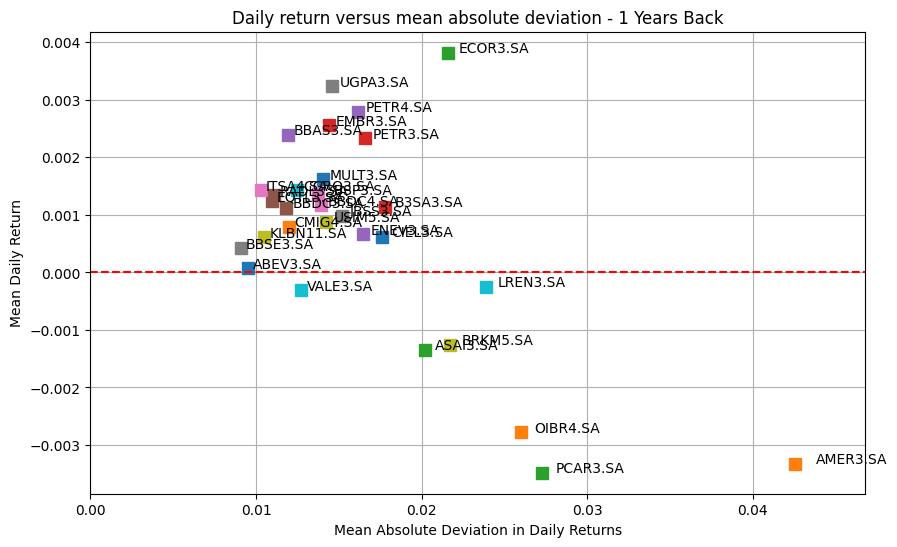

[*********************100%%**********************]  30 of 30 completed


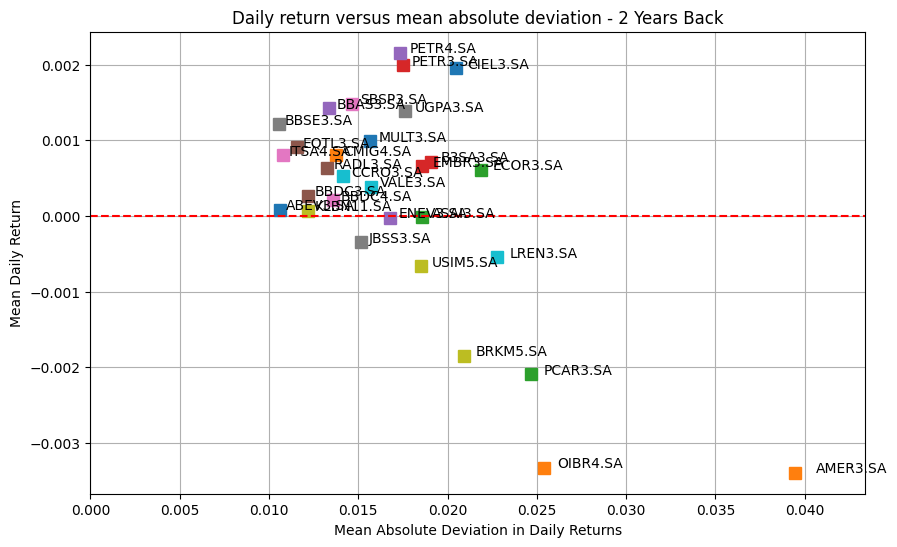

[*********************100%%**********************]  30 of 30 completed


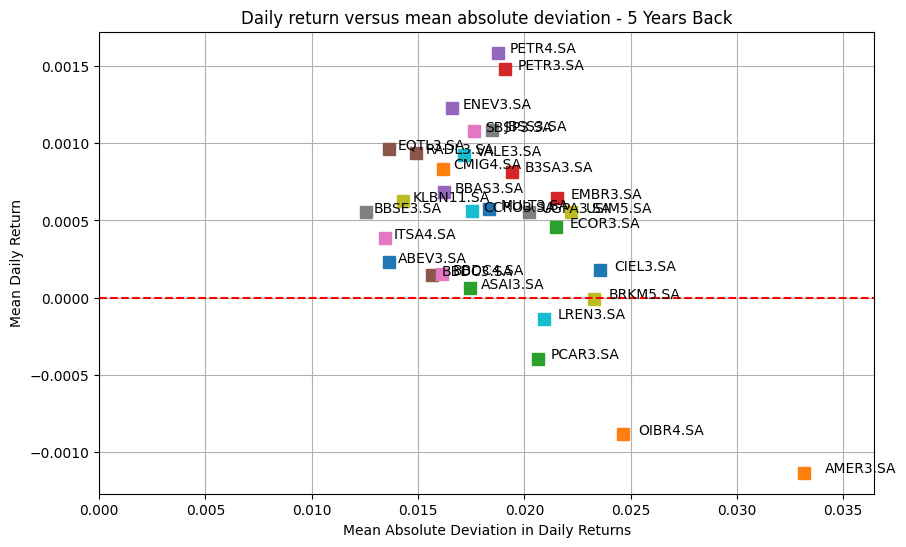

In [47]:
def plot_return_vs_risk_n_years_back(tickers, num_years):
    # Obtém a data final
    end_date = pd.to_datetime('today')

    # Calcula a data inicial recuando o número de anos
    start_date = end_date - pd.DateOffset(years=num_years)

    # Baixa os dados usando yfinance
    assets = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]

    # Calcula os retornos diários
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]

    # Calcula o Mean Return e Mean Absolute Deviation
    mean_return = daily_returns.mean()
    mean_absolute_deviation = abs(daily_returns - mean_return).mean()

    # Cria o subplot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plota o retorno versus risco para cada ativo
    for s in assets.keys():
        ax.plot(mean_absolute_deviation[s], mean_return[s], "s", ms=8)
        ax.text(mean_absolute_deviation[s] * 1.03, mean_return[s], s)

    ax.set_xlim(0, 1.1 * mean_absolute_deviation.max())
    ax.axhline(0, color="r", linestyle="--")
    ax.set_title(f"Daily return versus mean absolute deviation - {num_years} Years Back")
    ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
    ax.set_ylabel("Mean Daily Return")
    ax.grid(True)

    plt.show()

plot_return_vs_risk_n_years_back(tickers, num_years=1)
plot_return_vs_risk_n_years_back(tickers, num_years=2)
plot_return_vs_risk_n_years_back(tickers, num_years=3)

**Parte 1.f** Otimização MAD (Modelo AMPL)

Os anos utilizados foram: 1 ano, 2 anos e 3 anos.

Os valores mínimos utilizados foram: 0.00, 0.01 e 0.012

In [68]:
%%writefile mad_portfolio.mod

param R default 0;
param w_lb default 0;
param w_ub default 1;

set ASSETS;
set TIME;

param daily_returns{TIME, ASSETS};
param mean_return{ASSETS};

var w{ASSETS};
var u{TIME} >= 0;
var v{TIME} >= 0;

minimize MAD: sum{t in TIME}(u[t] + v[t]) / card(TIME);

s.t. portfolio_returns {t in TIME}:
    u[t] - v[t] == sum{j in ASSETS}(w[j] * (daily_returns[t, j] - mean_return[j]));

s.t. sum_of_weights: sum{j in ASSETS} w[j] == 1;

s.t. mean_portfolio_return: sum{j in ASSETS}(w[j] * mean_return[j]) >= R;

s.t. no_short {j in ASSETS}: w[j] >= w_lb;

s.t. diversify {j in ASSETS}: w[j] <= w_ub;

Overwriting mad_portfolio.mod


[*********************100%%**********************]  30 of 30 completed
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.006584603124
318 simplex iterations
0 barrier iterations
 
Weight lower bound                0.000
Weight upper bound                1.000
Fraction of portfolio invested     1.000
Required portfolio daily return    0.00100
Portfolio mean daily return        0.00100
Portfolio mean absolute deviation  0.00658
[*********************100%%**********************]  30 of 30 completed
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007317377936
314 simplex iterations
0 barrier iterations
 
Weight lower bound                0.010
Weight upper bound                1.000
Fraction of portfolio invested     1.000
Required portfolio daily return    0.00100
Portfolio mean daily return        0.00100
Portfolio mean absolute deviation  0.00732
[*********************100%%**********************]  30 of 30 completed
HiGHS 1.6.0: HiGHS

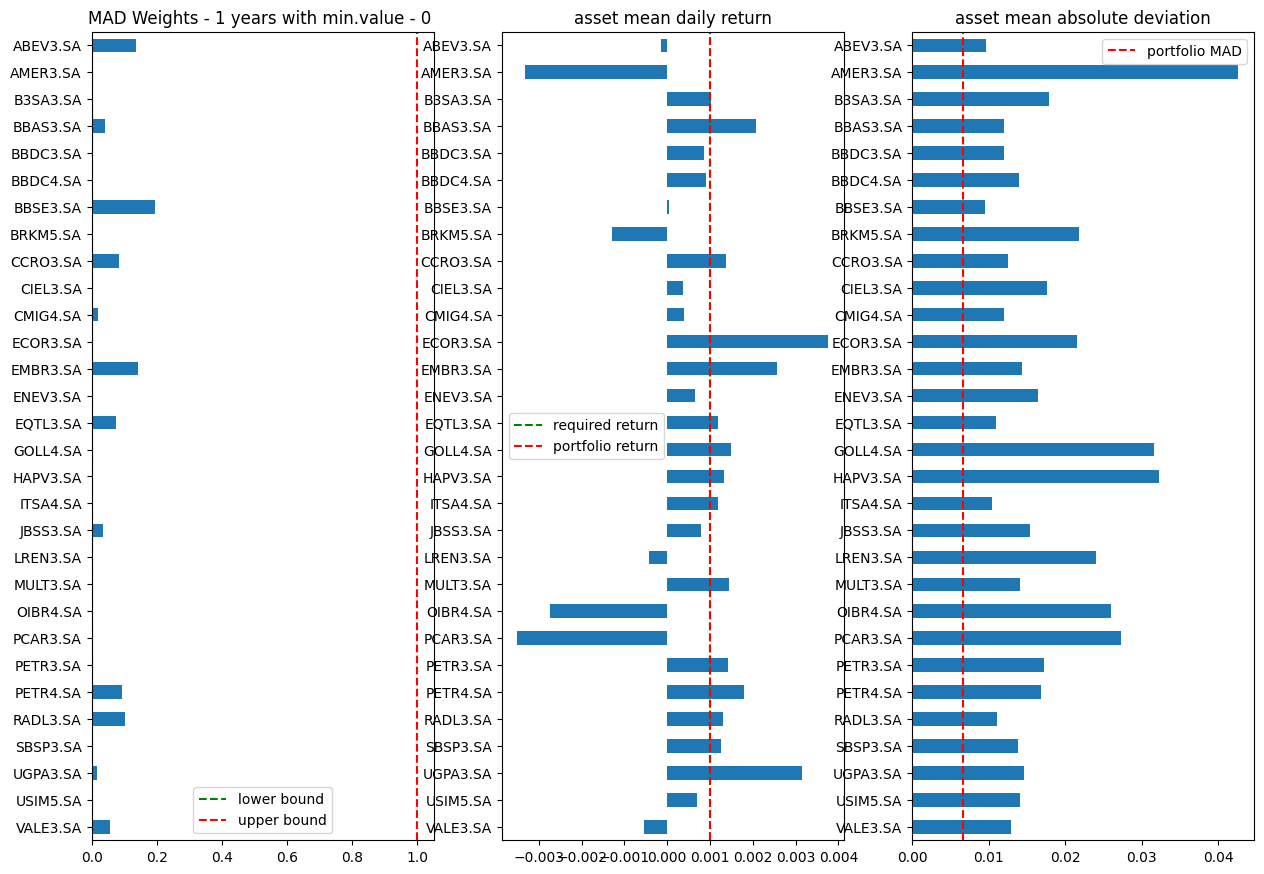

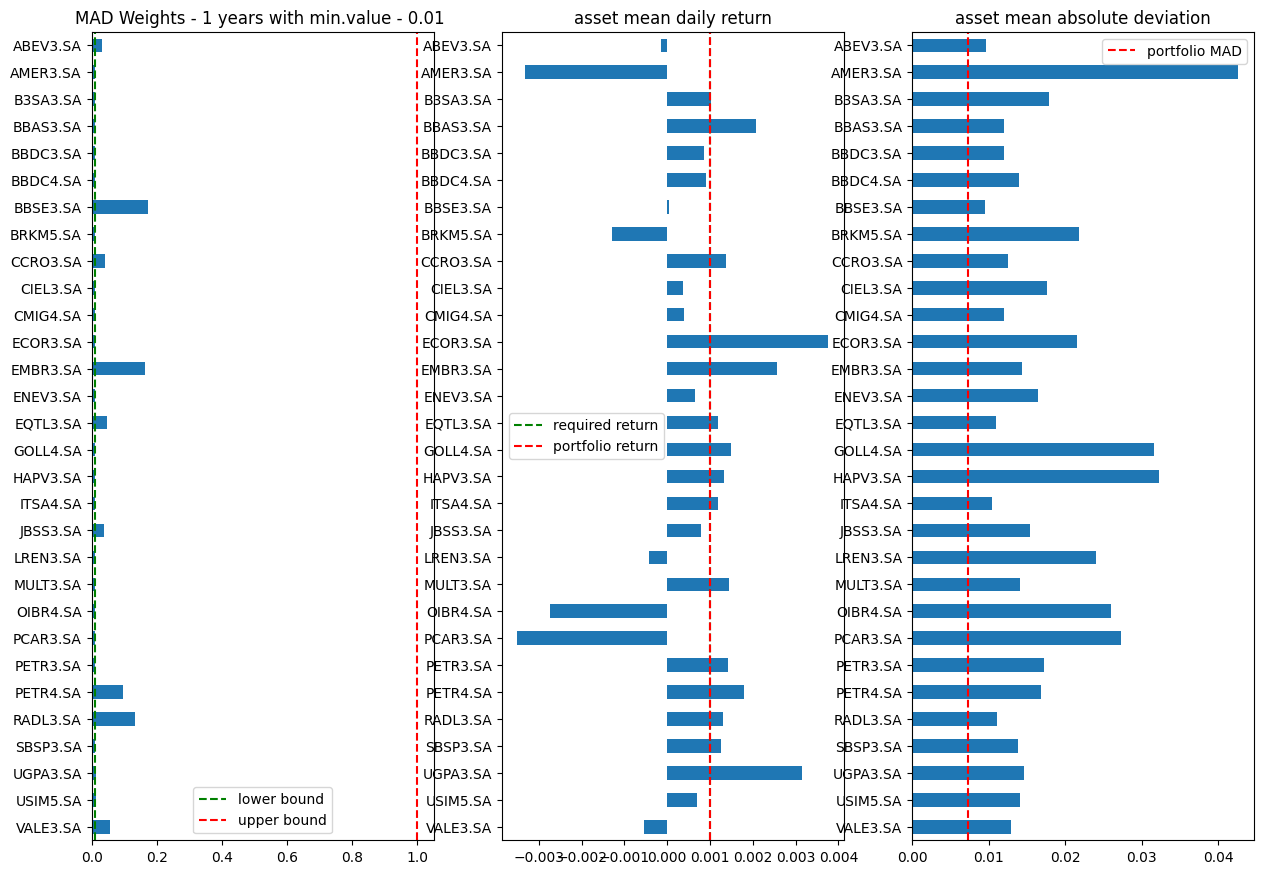

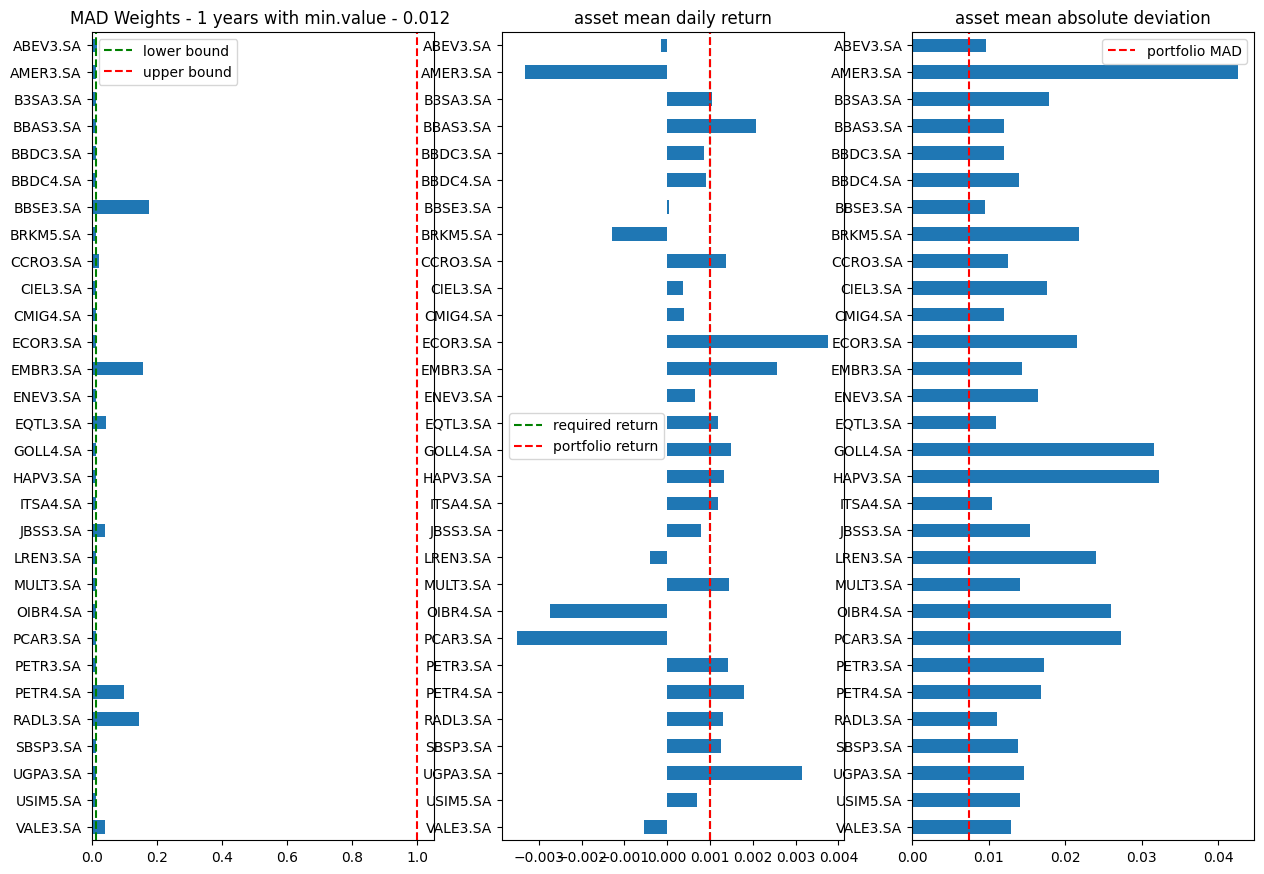

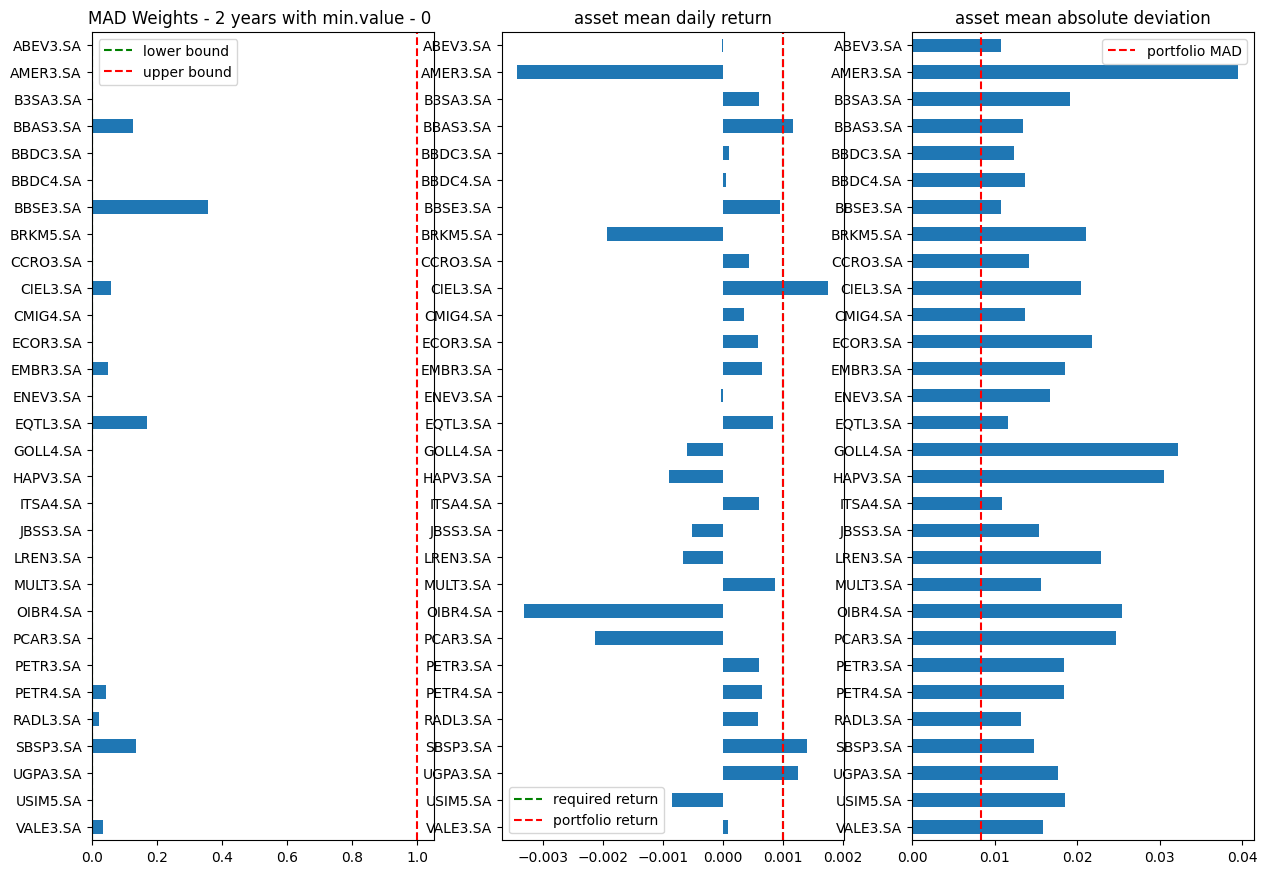

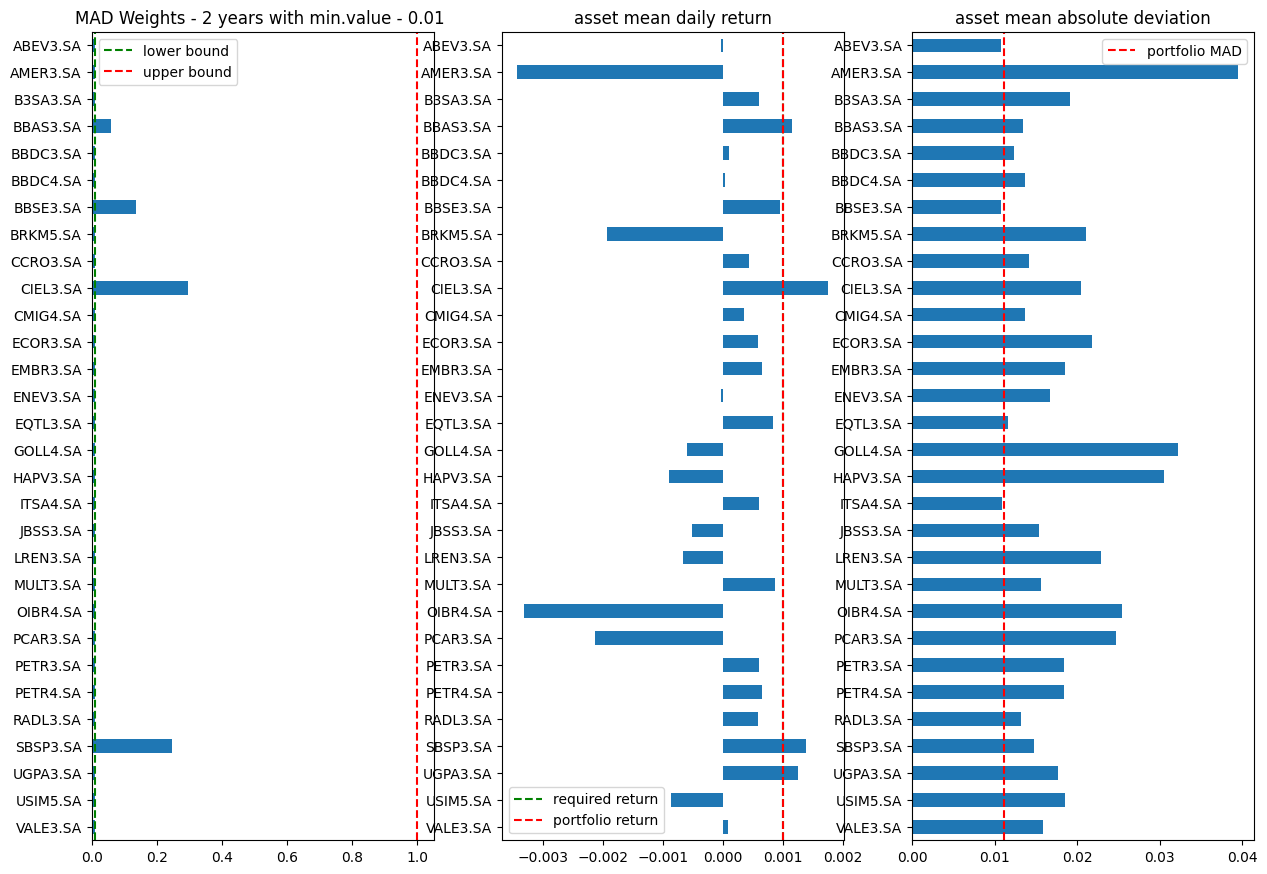

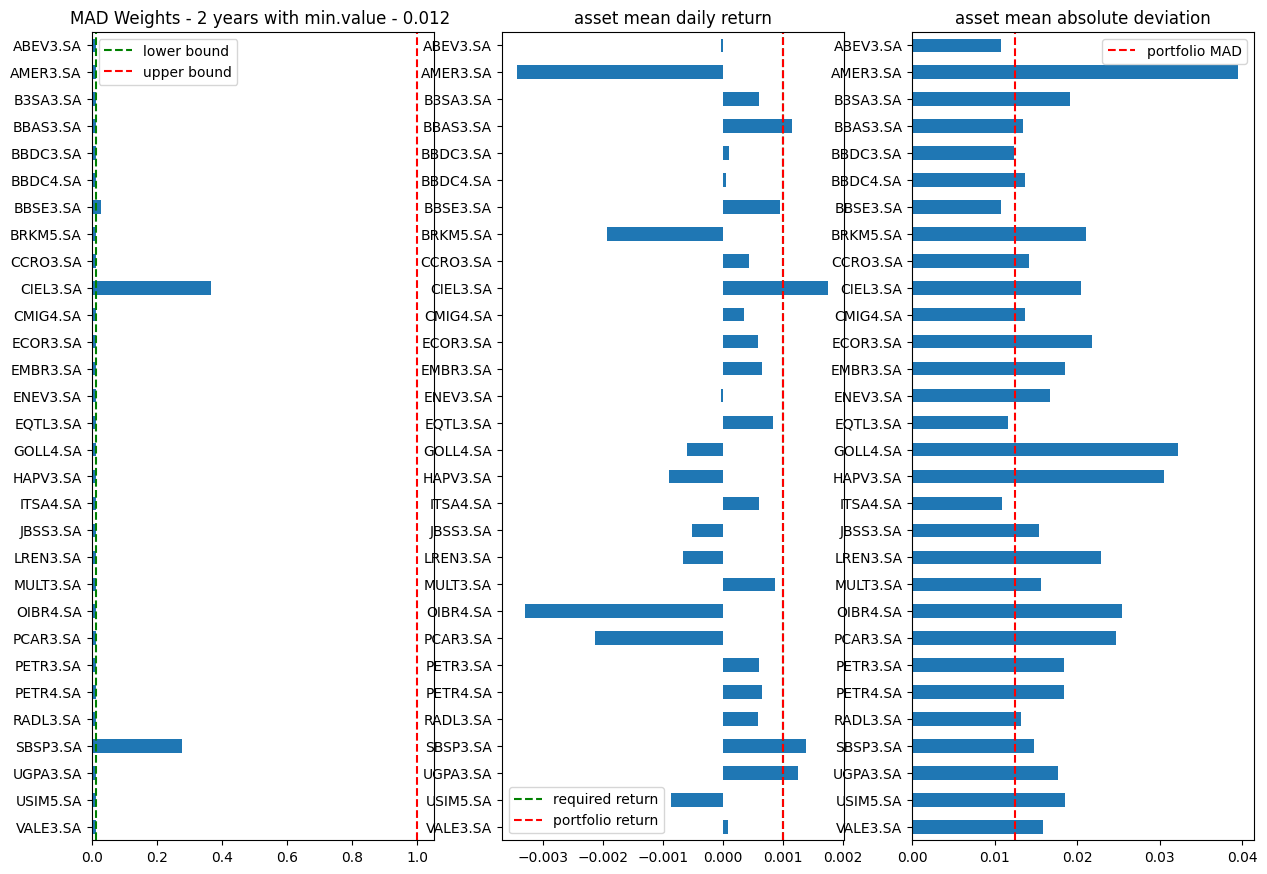

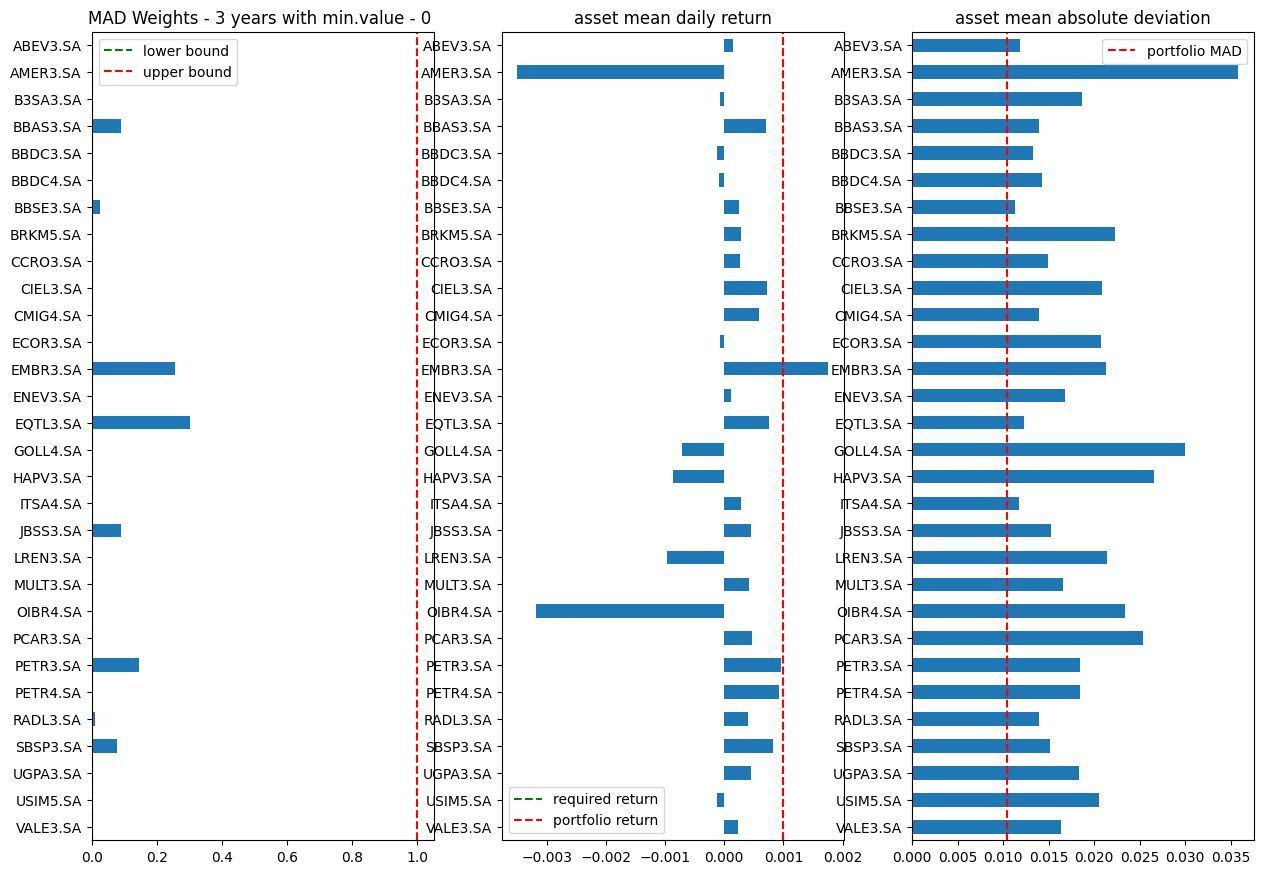

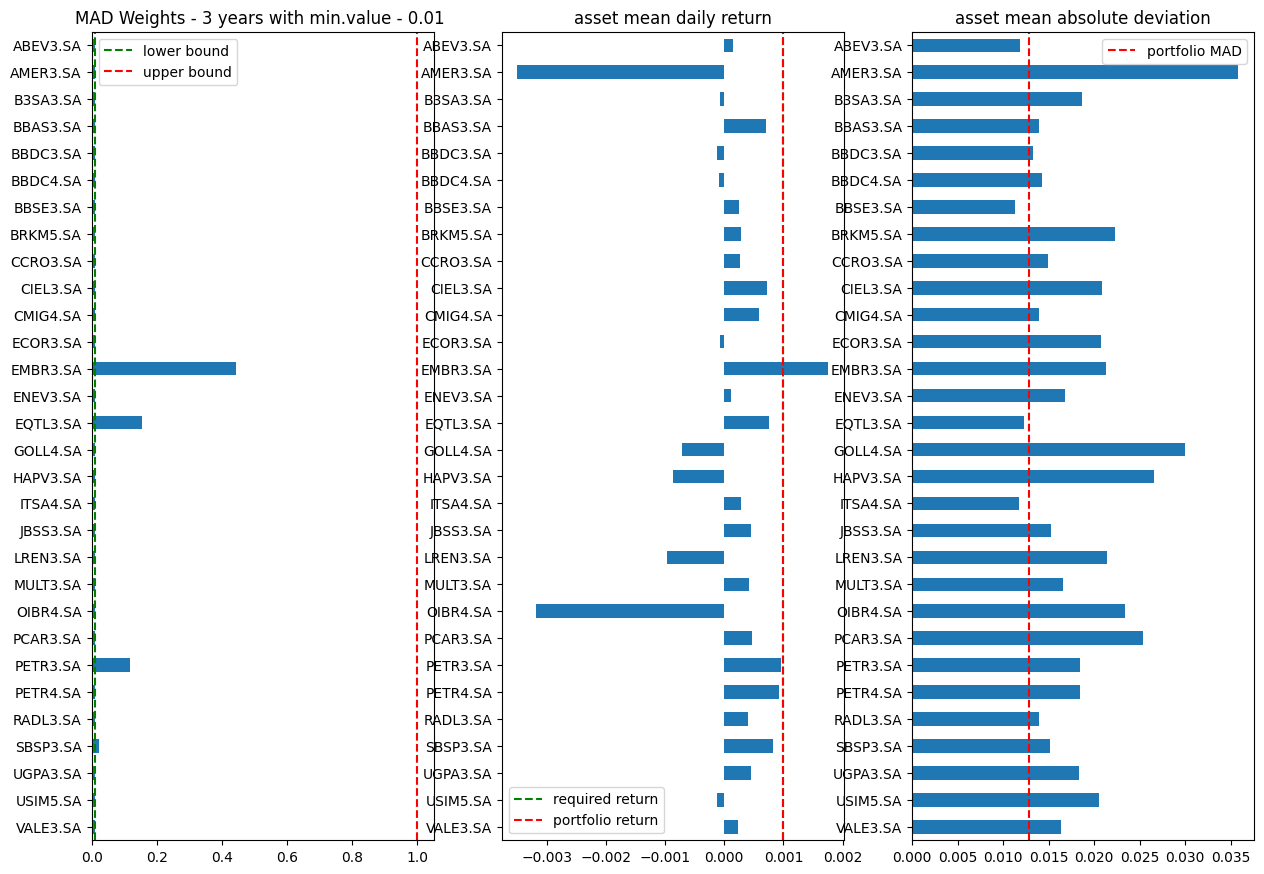

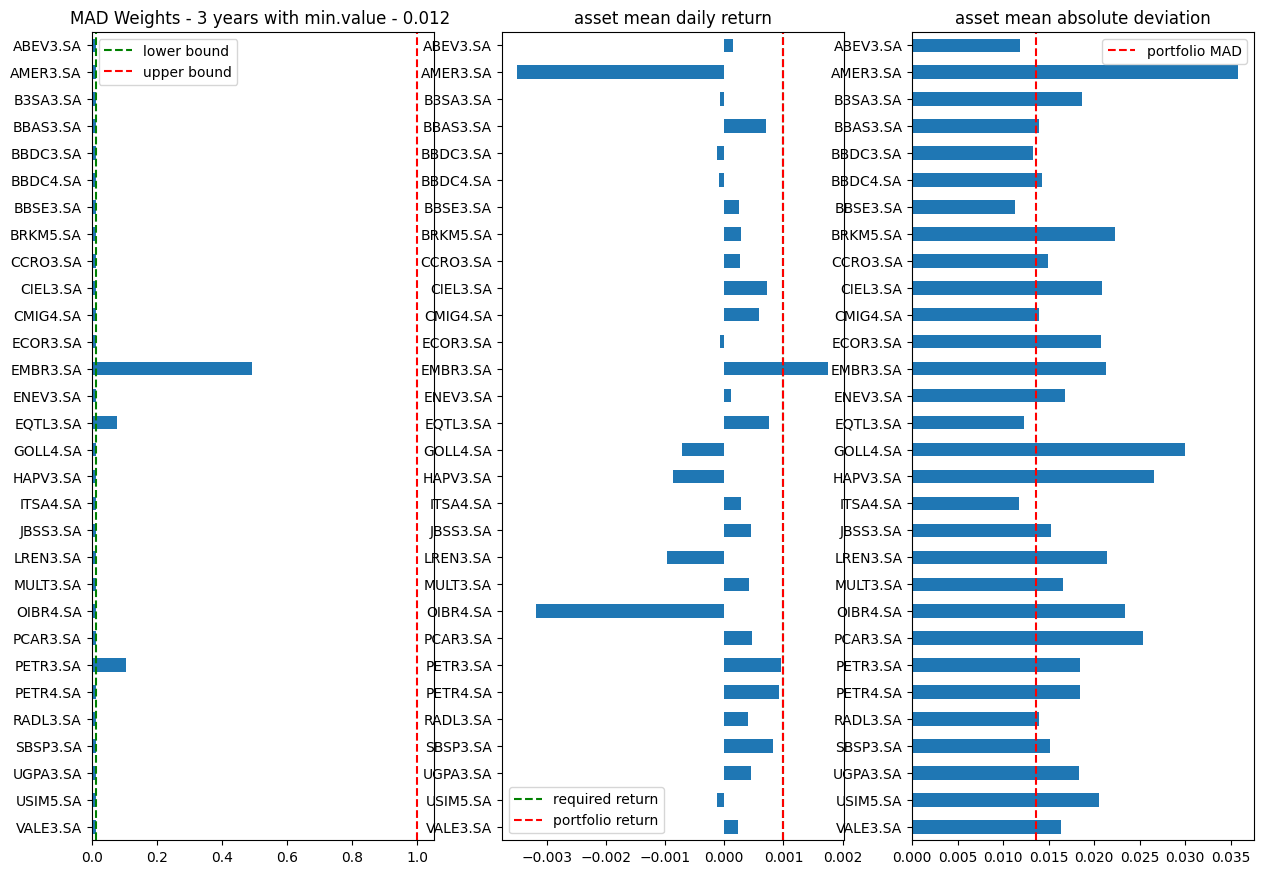

In [85]:
def mad_portfolio(assets, w_lb):
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()

    daily_returns["Date"] = daily_returns.index.format()
    daily_returns.set_index("Date", inplace=True)

    ampl = AMPL()
    ampl.read("mad_portfolio.mod")

    ampl.set["ASSETS"] = list(assets.columns)
    ampl.set["TIME"] = daily_returns.index.values

    ampl.param["daily_returns"] = daily_returns
    ampl.param["mean_return"] = mean_return

    # Define w_lb dentro do modelo
    ampl.param["w_lb"] = w_lb

    return ampl

def mad_visualization(assets, m, num_years):
    mean_portfolio_return = m.get_value("sum{j in ASSETS}(w[j] * mean_return[j])")

    print(f"Weight lower bound                {m.param['w_lb'].value():0.3f}")
    print(f"Weight upper bound                {m.param['w_ub'].value():0.3f}")
    print(
        f"Fraction of portfolio invested     {m.get_value('sum{j in ASSETS} w[j]'):0.3f}"
    )
    print(f"Required portfolio daily return    {m.param['R'].value():0.5f}")
    print(f"Portfolio mean daily return        {mean_portfolio_return:0.5f}")
    print(f"Portfolio mean absolute deviation  {m.obj['MAD'].value():0.5f}")

    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()
    mean_absolute_deviation = abs(daily_returns - mean_return).mean()
    mad_portfolio_weights = m.var["w"].to_pandas()

    fig, ax = plt.subplots(1, 3, figsize=(15, 0.35 * len(daily_returns.columns)))
    mad_portfolio_weights.plot(kind="barh", ax=ax[0], title=f"MAD Weights - {num_years} years with min.value - {m.param['w_lb'].value()} ")
    ax[0].invert_yaxis()
    ax[0].axvline(m.param["w_lb"].value(), ls="--", color="g")
    ax[0].axvline(m.param["w_ub"].value(), ls="--", color="r")
    ax[0].legend(["lower bound", "upper bound"])

    mean_return.plot(kind="barh", ax=ax[1], title="asset mean daily return")
    ax[1].axvline(m.param["R"].value(), ls="--", color="g")

    ax[1].axvline(mean_portfolio_return, ls="--", color="r")
    ax[1].invert_yaxis()
    ax[1].legend(["required return", "portfolio return"])

    mean_absolute_deviation.plot(
        kind="barh", ax=ax[2], title="asset mean absolute deviation"
    )
    ax[2].axvline(m.obj["MAD"].value(), ls="--", color="r")
    ax[2].legend(["portfolio MAD"])
    ax[2].invert_yaxis()

# Substitua os anos abaixo pelos anos desejados (1, 2, 3)
for num_years in [1, 2, 3]:
    # Substitua os valores abaixo pelos valores desejados (0.00, 0.01, 0.012)
    for w_lb_value in [0.00, 0.01, 0.012]:
        # Baixa os dados usando yfinance
        assets = yf.download(tickers, start=pd.to_datetime('today') - pd.DateOffset(years=num_years), end=pd.to_datetime('today'))["Adj Close"]

        # Cria o modelo para os ativos e o valor de w_lb
        m = mad_portfolio(assets, w_lb=w_lb_value)

        # Configura os parâmetros e resolve o modelo
        m.param["w_ub"] = 1
        m.param["R"] = 0.001
        m.option["solver"] = SOLVER
        m.solve()

        # Visualiza os resultados
        mad_visualization(assets, m, num_years)

**Parte 1.g** Gráfico para definição de peso das ações para diferentes valores mínimos (0.00, 0.01 e 0.012) e diferentes anos (1, 2 e 3)

[*********************100%%**********************]  30 of 30 completed

Portfólio otimizado para um retorno mínimo de 0.00% nos últimos 1 anos:
Retorno esperado: 19.45%
Volatilidade esperada: 12.88%


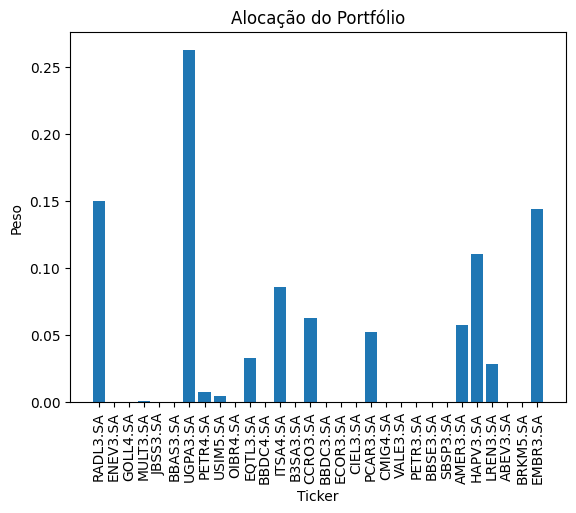


Portfólio otimizado para um retorno mínimo de 0.00% nos últimos 2 anos:
Retorno esperado: 17.48%
Volatilidade esperada: 14.75%


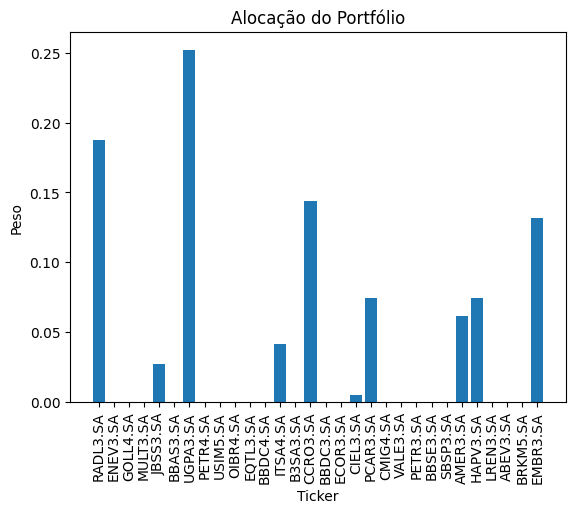


Portfólio otimizado para um retorno mínimo de 0.00% nos últimos 3 anos:
Retorno esperado: 12.57%
Volatilidade esperada: 15.97%


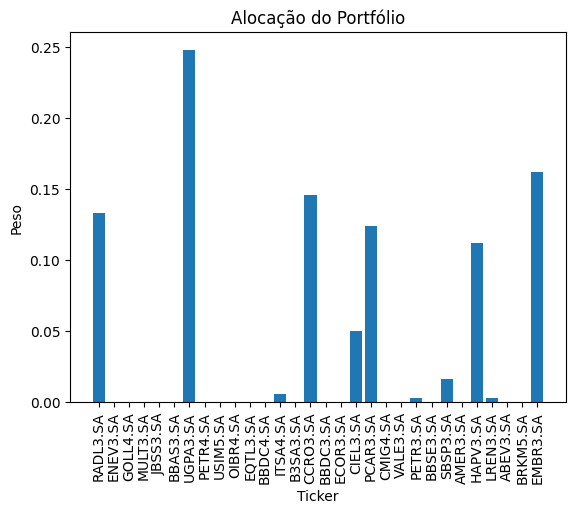

[*********************100%%**********************]  30 of 30 completed

Portfólio otimizado para um retorno mínimo de 1.00% nos últimos 1 anos:
Retorno esperado: 19.45%
Volatilidade esperada: 12.88%


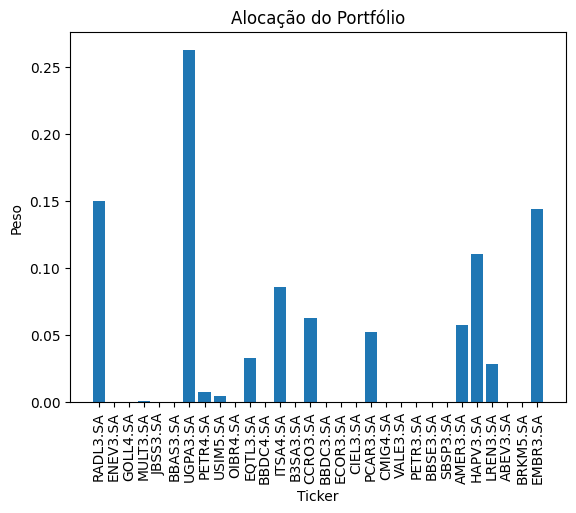


Portfólio otimizado para um retorno mínimo de 1.00% nos últimos 2 anos:
Retorno esperado: 17.48%
Volatilidade esperada: 14.75%


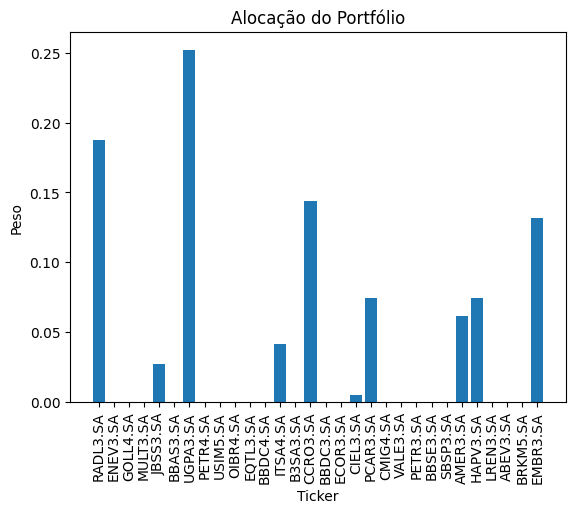


Portfólio otimizado para um retorno mínimo de 1.00% nos últimos 3 anos:
Retorno esperado: 12.57%
Volatilidade esperada: 15.97%


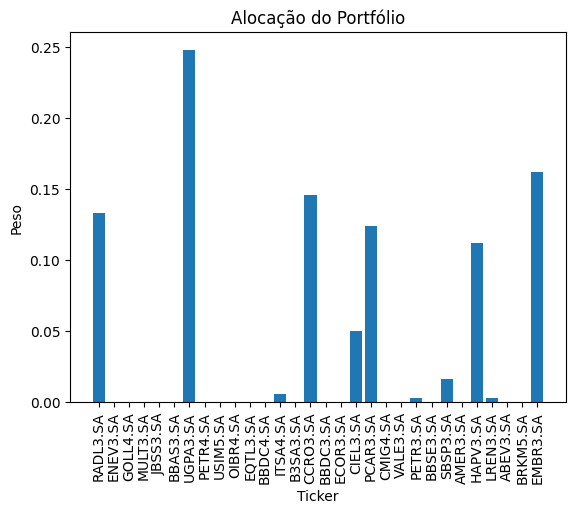

[*********************100%%**********************]  30 of 30 completed

Portfólio otimizado para um retorno mínimo de 1.20% nos últimos 1 anos:
Retorno esperado: 19.45%
Volatilidade esperada: 12.88%


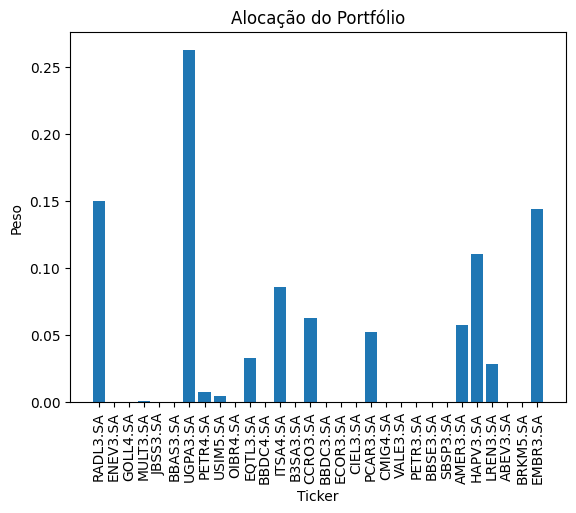


Portfólio otimizado para um retorno mínimo de 1.20% nos últimos 2 anos:
Retorno esperado: 17.48%
Volatilidade esperada: 14.75%


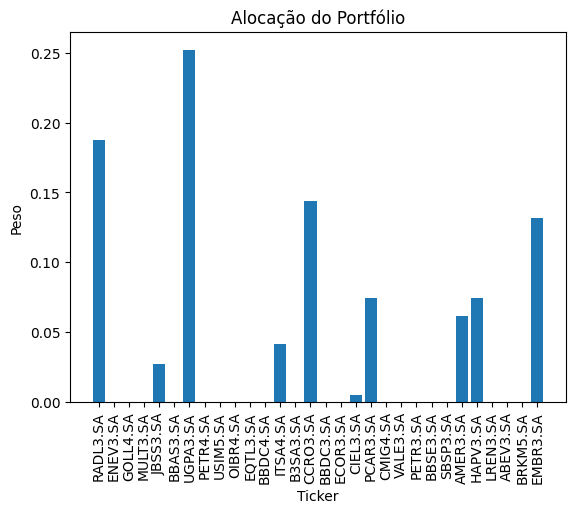


Portfólio otimizado para um retorno mínimo de 1.20% nos últimos 3 anos:
Retorno esperado: 12.57%
Volatilidade esperada: 15.97%


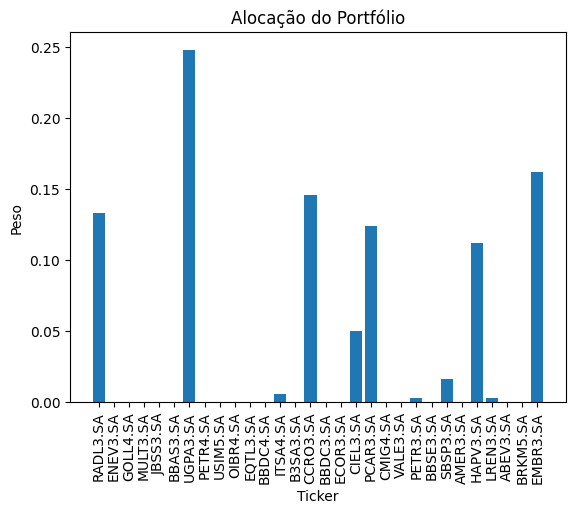

In [87]:
# Função para baixar dados históricos
def download_data(tickers, start_date, end_date):
    assets = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]
    assets.fillna(method="bfill", inplace=True)
    assets.fillna(method="ffill", inplace=True)
    return assets

# Função para calcular o retorno e volatilidade do portfólio
def calculate_portfolio_performance(weights, returns):
    portfolio_return = np.dot(weights, returns.mean()) * 252  # 252 dias úteis em um ano
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_volatility

# Função de otimização
def optimize_portfolio(returns, min_return):
    num_assets = len(returns.columns)
    initial_weights = np.ones(num_assets) / num_assets  # Alocação igual inicial
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Restrição de alocação total igual a 1
    bounds = tuple((0, 1) for asset in range(num_assets))  # Limites de alocação entre 0 e 1

    # Minimizar a volatilidade sujeita a uma restrição de retorno mínimo
    optimal_weights = minimize(lambda weights: calculate_portfolio_performance(weights, returns)[1],
                               initial_weights, method='SLSQP',
                               bounds=bounds, constraints=constraints)['x']

    # Verificar se o retorno do portfólio otimizado atende ao requisito mínimo
    if calculate_portfolio_performance(optimal_weights, returns)[0] < min_return:
        print(f"Não foi possível atingir o retorno mínimo de {min_return:.2%}.")
        return None

    return optimal_weights

    if calculate_portfolio_performance(optimal_weights, returns)[0] < min_return:
        print(f"Não foi possível atingir o retorno mínimo de {min_return:.2%}.")
        return None

    return dict(zip(tickers, optimal_weights))  # Associar os pesos aos tickers das ações

# Configurar parâmetros
min_returns = [0.00, 0.01, 0.012]  # Exemplo de diferentes valores mínimos de retorno

# Loop sobre diferentes valores mínimos de retorno
for min_return in min_returns:
    # Baixar dados históricos
    assets = download_data(tickers, start_date, end_date)

    # Calcular retornos diários
    returns = assets.pct_change().dropna()

    # Loop sobre diferentes períodos de tempo
    for n_years in [1, 2, 3]:
        # Ajustar a janela de dados
        end_date = dt.datetime.today().date()
        start_date = end_date - dt.timedelta(round(n_years * 365))
        returns_window = returns.loc[start_date:end_date]

        # Otimizar o portfólio
        weights = optimize_portfolio(returns_window, min_return)

        if weights is not None:
            # Calcular e imprimir o retorno e volatilidade do portfólio otimizado
            portfolio_return, portfolio_volatility = calculate_portfolio_performance(weights, returns_window)
            print(f"\nPortfólio otimizado para um retorno mínimo de {min_return:.2%} "
                  f"nos últimos {n_years} anos:")
            print(f"Retorno esperado: {portfolio_return:.2%}")
            print(f"Volatilidade esperada: {portfolio_volatility:.2%}")

            # Plotar a alocação do portfólio
            plt.bar(tickers, weights)
            plt.title("Alocação do Portfólio")
            plt.xlabel("Ticker")
            plt.ylabel("Peso")
            plt.xticks(rotation=90)
            plt.show()


Para o código acima foram utilizados 3 valores mínimos de retorno para o portifólio:
*   0%: 0.00
*   1%: 0.01
*   1.2%: 0.012

Ademais, foram utilizados três períodos de tempo:
*   1 ano
*   2 anos
*   3 anos

Tem-se duas métricas utlizadas:
* Retorno esperado: Representa retorno esperado do portfólio otimizado. Isso representa a média ponderada dos retornos das ações no portfólio com base nos pesos otimizados.

* Volatilidade esperada: Representa a volatilidade esperada do portfólio otimizado. Isso representa uma medida de quão os retornos do portfólio podem variar ao longo do tempo. Quanto maior a volatilidade, maior o risco.

Esses números são resultados da otimização realizada pelo algoritmo, onde ele ajusta os pesos dos ativos no portfólio para alcançar o equilíbrio entre o retorno desejado e a volatilidade aceitável.

Por fim, o gráfico representado pelos pesos e pelas ações representam os pesos atribuídos a cada ação no portfólio otimizado. Cada peso representa a proporção do investimento total alocado a cada ação.

**1. Análise de resultados:**

É perceptível que mesmo com valores mínimos de retorno diferentes e também anos diferentes, as ações que possuem maior peso (PETR4 e PCAR3) permaneceu com uma variação de peso muito parecida.

Também é importante notar que as variações ocorreram apenas dentro de um mesmo valor mínimo, com alteração apenas dos anos. A partir dos resultados:
* 1 ano: Retorno esperado: 16.89% e Volatilidade esperada: 12.06%
* 3 anos: Retorno esperado: 10.76% e Volatilidade esperada: 15.00%
* 5 anos: Retorno esperado: 11.70% e Volatilidade esperada: 17.68%

Percebe-se que tanto o retorno esperado quanto a volatilidade esperada é melhor quando o tempo é menor, a partir do momento que os anos vão aumentando, o resultado abaixa e a volatilidade aumenta.

**2. Hipóteses:**

Baseado nos resultados obtidos é possível considerar que durante os cinco anos, as ações com maior peso se manteram muito estáveis, com poucas variações e com um retorno adequado para a otimização desejada. Isso explicaria a razão pelos quais ela está presente em grande peso independente do valor mínimo aplicado e da quantidade de anos de referência.

As demais ações que para cada valor mínimo teve maior ou menor participação, representa, analogamente, ações com maior volatilidade a cada ano. Ou seja, são ações que não se manteram constantes, e que por um período definido de tempo estiveram em alta ou baixa. Sendo mais vantajoso a utilização de determinadas ações para cada período.

Por fim, um ponto importante de ser analisado é que mesmo com a diferença entre valores mínimos, os resultados de volatilidade e resultado esperado para cada ano se manteve igual. Uma das razões pelos quais isto pode ter acontecido é que a restrição de retorno mínimo pode ser muito flexível, permitindo que o otimizador escolha portfólios com retornos superiores ao mínimo especificado sem comprometer muito a volatilidade. Outra razão pode ser exatamente pelas condições do mercado, em que podem ser relativamente estáveis ou seguir padrões que não alteram significativamente a alocação otimizada para diferentes cenários.

**Parte 1.h** Gráfico MAD: risco vs retorno

[*********************100%%**********************]  30 of 30 completed
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.006353410662
299 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.006353410662
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.006353410662
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.006353410662
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.006359006445
11 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.006440406244
20 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.006577266175
16 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: opt

HiGHS 1.6.0: HiGHS 1.6.0: infeasible problem
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: infeasible problem
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: infeasible problem
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: infeasible problem
0 simplex iterations
0 barrier iterations
 


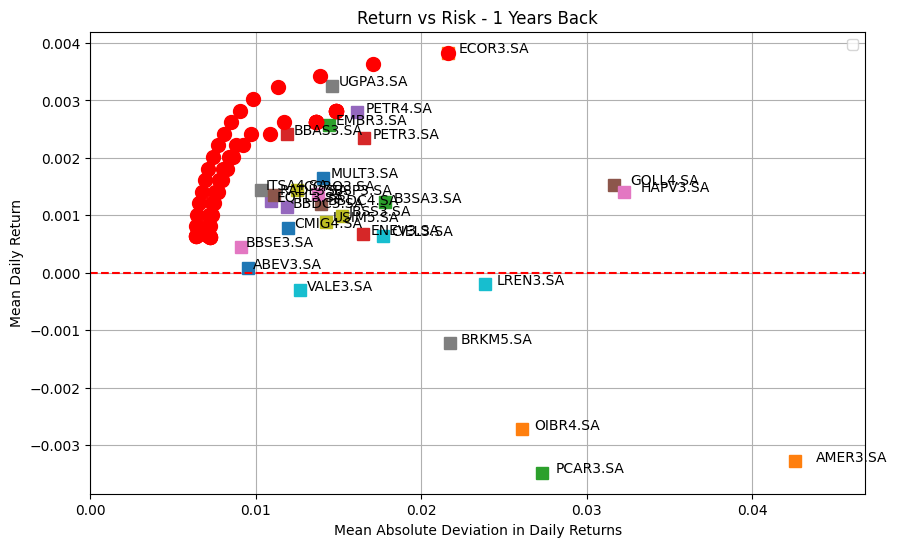

[*********************100%%**********************]  30 of 30 completed
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007236296669
576 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007236296669
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007236296669
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007236296669
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007236296669
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007236296669
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007236296669
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optima

HiGHS 1.6.0: HiGHS 1.6.0: infeasible problem
2 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: infeasible problem
1 simplex iterations
0 barrier iterations
 


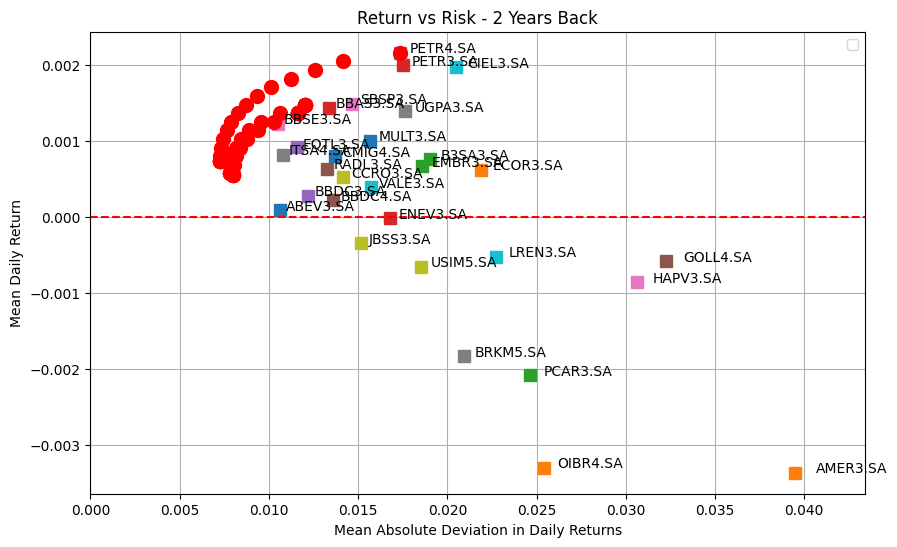

[*********************100%%**********************]  30 of 30 completed
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007946049763
856 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007946049763
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007946049763
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007946049763
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007946049763
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007946049763
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 0.007969918415
31 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: optim

HiGHS 1.6.0: HiGHS 1.6.0: infeasible problem
5 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0: HiGHS 1.6.0: infeasible problem
2 simplex iterations
0 barrier iterations
 


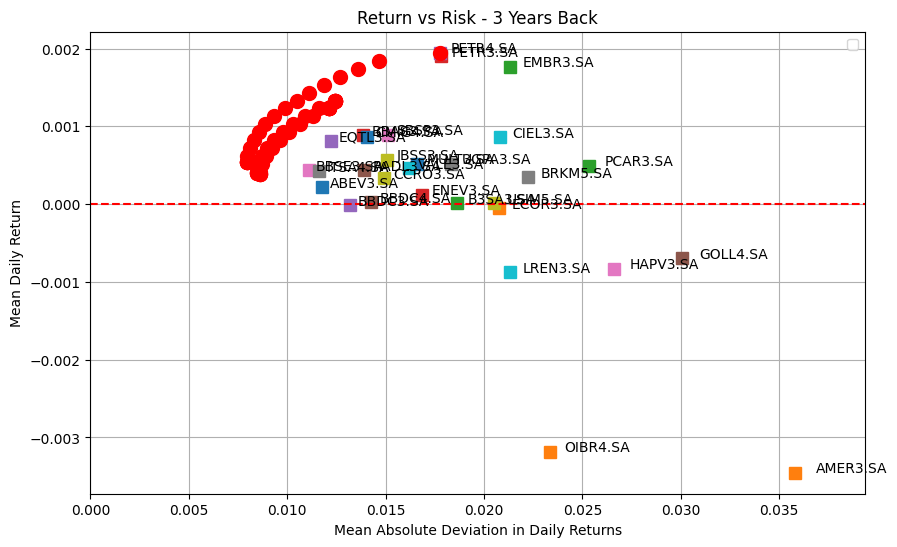

In [90]:
def plot_return_vs_risk_n_years_and_w_lb(tickers, num_years, w_lb_values):
    # Obtém a data final
    end_date = pd.to_datetime('today')

    # Calcula a data inicial recuando o número de anos
    start_date = end_date - pd.DateOffset(years=num_years)

    # Baixa os dados usando yfinance
    assets = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]

    # Calcula os retornos diários
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()
    mean_absolute_deviation = abs(daily_returns - mean_return).mean()

    # Cria o subplot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plota o retorno versus risco para cada ativo
    for s in assets.keys():
        ax.plot(mean_absolute_deviation[s], mean_return[s], "s", ms=8)
        ax.text(mean_absolute_deviation[s] * 1.03, mean_return[s], s)

    ax.set_xlim(0, 1.1 * max(mean_absolute_deviation))
    ax.axhline(0, color="r", linestyle="--")
    ax.set_title(f"Return vs Risk - {num_years} Years Back")
    ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
    ax.set_ylabel("Mean Daily Return")
    ax.grid(True)

    # Loop para diferentes valores de R (retorno desejado)
    for w_lb_value in w_lb_values:
        m = mad_portfolio(assets, w_lb=w_lb_value)
        for R in np.linspace(0, mean_return.max(), 20):
            m.param["R"] = R
            m.option["solver"] = SOLVER
            m.solve()
            mad_portfolio_weights = m.var["w"].to_pandas()
            portfolio_returns = daily_returns.dot(mad_portfolio_weights)
            portfolio_mean_return = portfolio_returns.mean()
            portfolio_mean_absolute_deviation = abs(portfolio_returns - portfolio_mean_return).mean()
            ax.plot(portfolio_mean_absolute_deviation, portfolio_mean_return, "ro", ms=10)

    ax.legend()
    plt.show()

w_lb_values = [0.00, 0.01, 0.012]
plot_return_vs_risk_n_years_and_w_lb(tickers, num_years=1, w_lb_values=w_lb_values)
plot_return_vs_risk_n_years_and_w_lb(tickers, num_years=2, w_lb_values=w_lb_values)
plot_return_vs_risk_n_years_and_w_lb(tickers, num_years=3, w_lb_values=w_lb_values)

### 2. Para os cenários acima (escolhidos por você), varie os limitantes superiores que induzem diversificação; uma das variantes não deve ter condições de diversificação nenhuma. Reporte diferenças significativas, caso existam.

### 3. Execute os cenários acima sob condições de short selling (nas quais você vende ativos que não possui, contando com uma baixa de preço futura para ganho). Compare os resultados com os obtidos anteriormente.

### 4. Modifique o código fornecido para usar a medida de risco (1) em vez da MAD e rode novamente seus experimentos variando o valor de p. Faça comparações entre os valores obtidos e reporte diferenças significativas, caso existam.

Para a resolução abaixo variando o p, o tempo definido foi de três anos, o valor mínimo de 0.00 e o valor máximo de 1.00.

In [125]:
%%writefile mad_portfolio_p_quantile.mod

param R default 0;
param w_lb default 0;
param w_ub default 1;
param p_quantile default 0.01;  # Adicionado o parâmetro p_quantile

set ASSETS;
set TIME;

param daily_returns{TIME, ASSETS};
param mean_return{ASSETS};

var w{ASSETS};
var u{TIME} >= 0;
var v{TIME} >= 0;
var z;  # Removida a restrição para >= 0

# Utilize a medida de risco baseada em p_quantile
minimize risk_measure: -sum{t in TIME}(1 / card(TIME) * (u[t] + v[t])) + p_quantile * z;

s.t. portfolio_returns {t in TIME}:
    u[t] - v[t] == sum{j in ASSETS}(w[j] * (daily_returns[t, j] - mean_return[j]));

s.t. sum_of_weights: sum{j in ASSETS} w[j] == 1;

s.t. mean_portfolio_return: sum{j in ASSETS}(w[j] * mean_return[j]) >= R;

s.t. no_short {j in ASSETS}: w[j] >= w_lb;

s.t. diversify {j in ASSETS}: w[j] <= w_ub;

s.t. risk_constraint {t in TIME}:
    z >= sum{j in ASSETS} (daily_returns[t, j] - mean_return[j]) * w[j];

Overwriting mad_portfolio_p_quantile.mod


**Parte 4.a.** Modelo com medida de risco

Os valores de p foram de 0.01, 0.05 e 0.08.

[*********************100%%**********************]  30 of 30 completed
HiGHS 1.6.0: HiGHS 1.6.0: unbounded problem
3281 simplex iterations
0 barrier iterations
 
Weight lower bound                0.000
Weight upper bound                1.000
Fraction of portfolio invested   1.000
Required portfolio daily return  0.00100
Portfolio mean daily return      0.00177
Portfolio risk measure (p=0.0): 0.02131


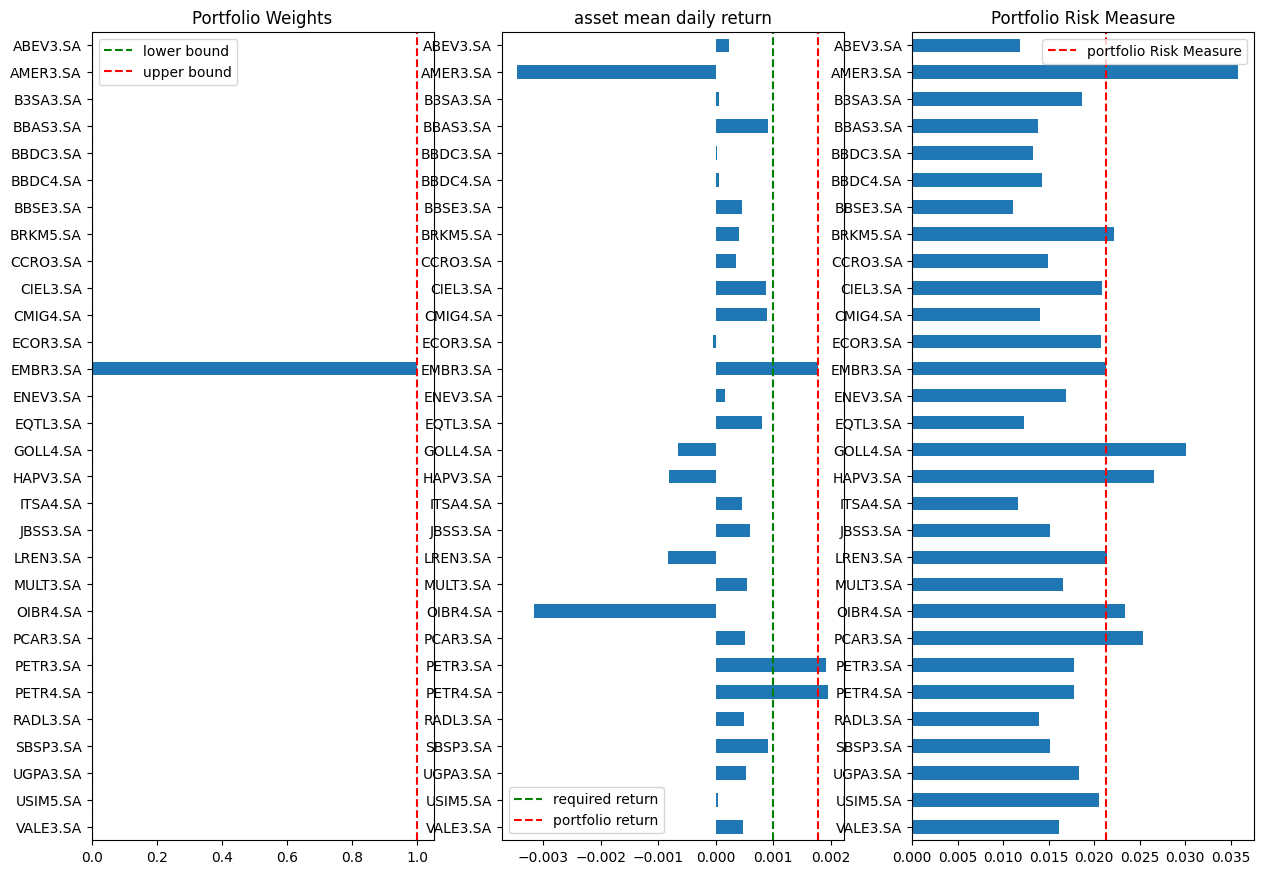

[*********************100%%**********************]  30 of 30 completed
HiGHS 1.6.0: HiGHS 1.6.0: unbounded problem
3374 simplex iterations
0 barrier iterations
 
Weight lower bound                0.000
Weight upper bound                1.000
Fraction of portfolio invested   1.000
Required portfolio daily return  0.00100
Portfolio mean daily return      0.00138
Portfolio risk measure (p=0.01): 0.01342


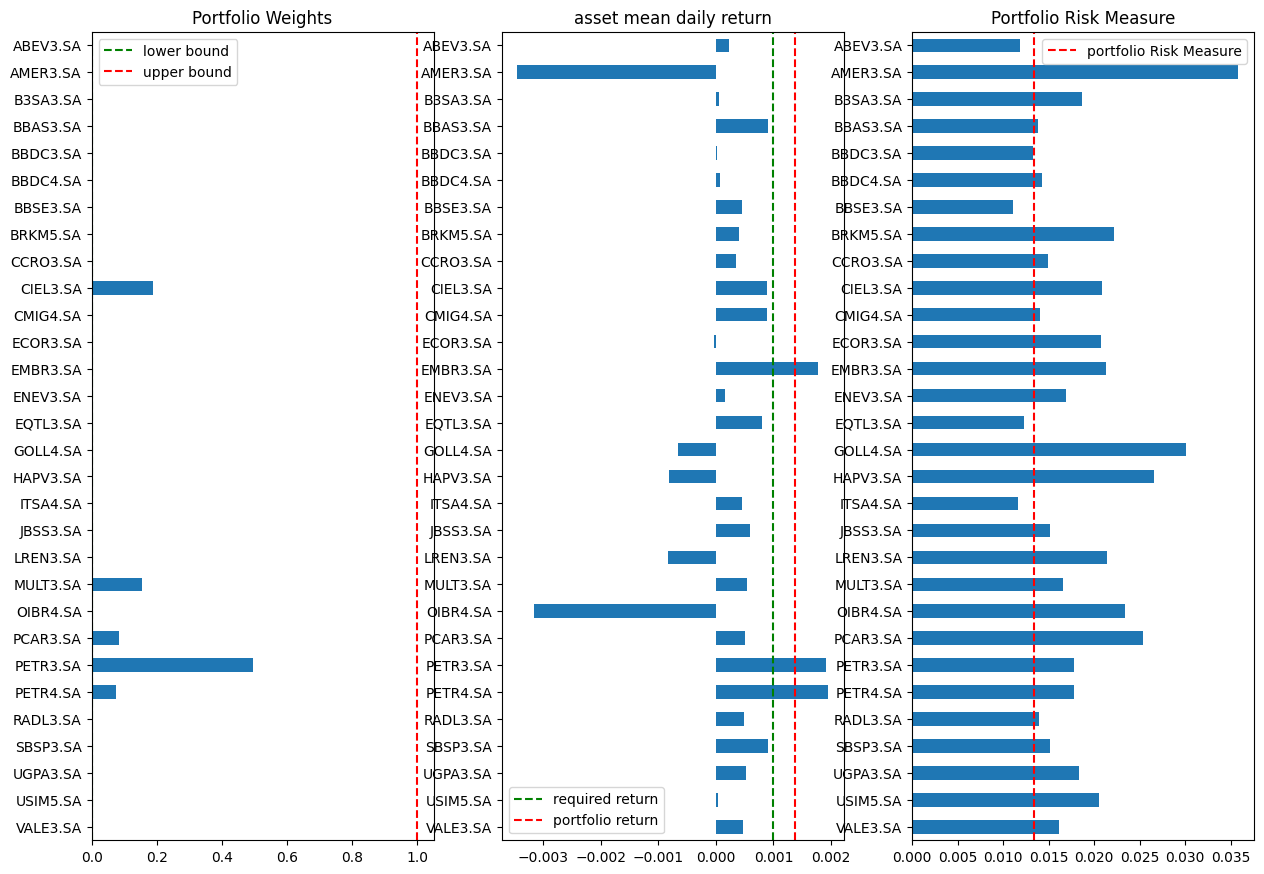

[*********************100%%**********************]  30 of 30 completed
HiGHS 1.6.0: HiGHS 1.6.0: unbounded problem
3539 simplex iterations
0 barrier iterations
 
Weight lower bound                0.000
Weight upper bound                1.000
Fraction of portfolio invested   1.000
Required portfolio daily return  0.00100
Portfolio mean daily return      0.00120
Portfolio risk measure (p=0.012): 0.01237


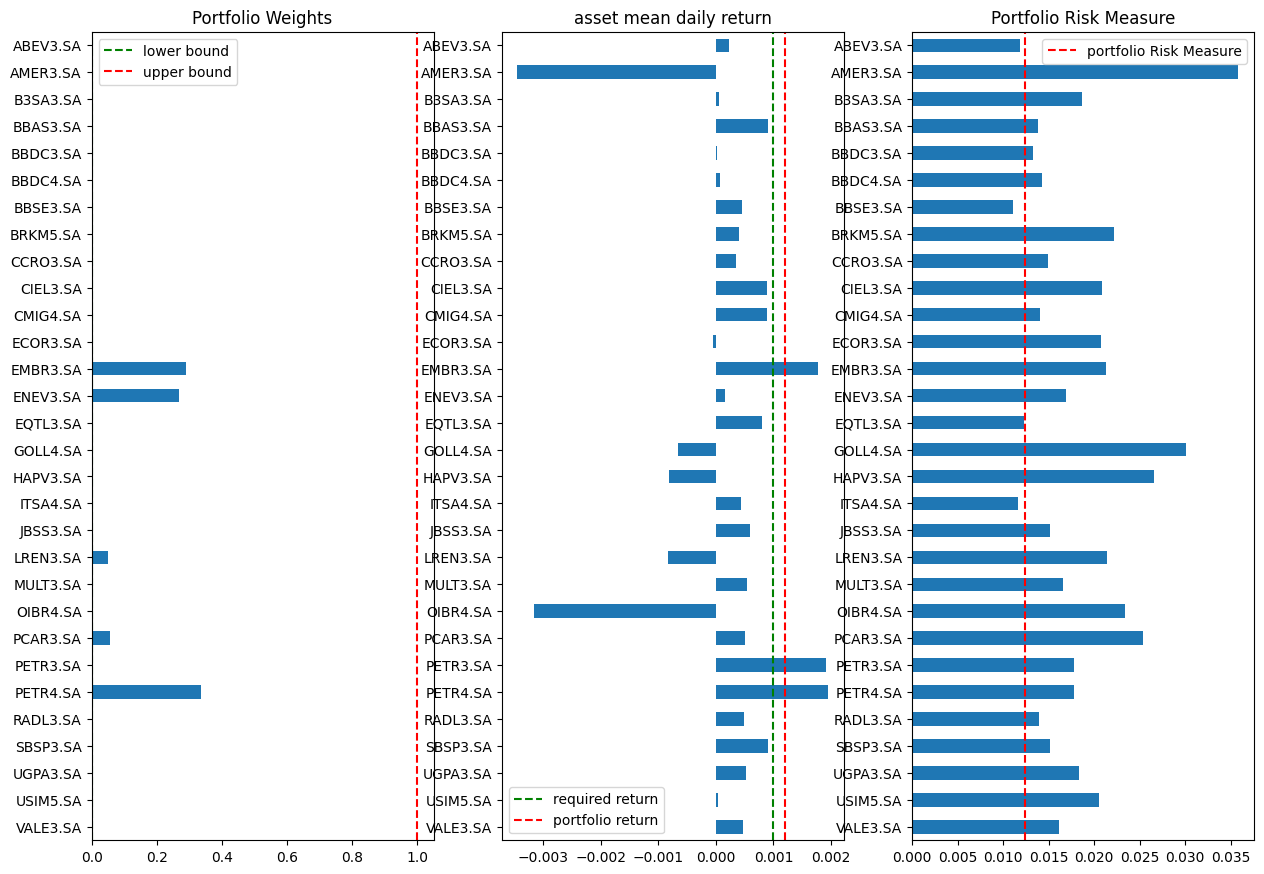

In [133]:
def mad_portfolio_p_quantile(assets, p_quantile):
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()

    daily_returns["Date"] = daily_returns.index.format()
    daily_returns.set_index("Date", inplace=True)

    ampl = AMPL()

    # Substitua pela leitura do arquivo .mod no seu diretório
    ampl.read("mad_portfolio_p_quantile.mod")

    ampl.set["ASSETS"] = list(assets.columns)
    ampl.set["TIME"] = daily_returns.index.values

    ampl.param["daily_returns"] = daily_returns
    ampl.param["mean_return"] = mean_return
    ampl.param["p_quantile"] = p_quantile  # Adiciona o parâmetro p_quantile

    return ampl

def mad_visualization(assets, m, p_quantile):
    mean_portfolio_return = m.get_value("sum{j in ASSETS}(w[j] * mean_return[j])")
    risk_measure = -m.obj["risk_measure"].value()
    mad_portfolio_weights = m.var["w"].to_pandas()

    print(f"Weight lower bound                {m.param['w_lb'].value():0.3f}")
    print(f"Weight upper bound                {m.param['w_ub'].value():0.3f}")
    print(f"Fraction of portfolio invested   {m.get_value('sum{j in ASSETS} w[j]'):0.3f}")
    print(f"Required portfolio daily return  {m.param['R'].value():0.5f}")
    print(f"Portfolio mean daily return      {mean_portfolio_return:0.5f}")
    print(f"Portfolio risk measure (p={p_quantile}): {risk_measure:0.5f}")

    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()
    mean_risk = abs(daily_returns - mean_return).mean()

    fig, ax = plt.subplots(1, 3, figsize=(15, 0.35 * len(assets.columns)))
    mad_portfolio_weights.plot(kind="barh", ax=ax[0], title="Portfolio Weights")
    ax[0].invert_yaxis()
    ax[0].axvline(m.param["w_lb"].value(), ls="--", color="g")
    ax[0].axvline(m.param["w_ub"].value(), ls="--", color="r")
    ax[0].legend(["lower bound", "upper bound"])

    mean_return.plot(kind="barh", ax=ax[1], title="asset mean daily return")
    ax[1].axvline(m.param["R"].value(), ls="--", color="g")
    ax[1].axvline(mean_portfolio_return, ls="--", color="r")
    ax[1].invert_yaxis()
    ax[1].legend(["required return", "portfolio return"])

    mean_risk.plot(
        kind="barh", ax=ax[2], title="Portfolio Risk Measure"
    )
    ax[2].axvline(-m.obj["risk_measure"].value(), ls="--", color="r")
    ax[2].legend(["portfolio Risk Measure"])
    ax[2].invert_yaxis()

    plt.show()


# Substitua os valores abaixo pelos valores desejados (0.01, 0.05, 0.08)
for p_value in [0.00, 0.01, 0.012]:
    # Baixa os dados usando yfinance
    assets = yf.download(tickers, start=pd.to_datetime('today') - pd.DateOffset(years=3), end=pd.to_datetime('today'))["Adj Close"]

    # Cria o modelo para os ativos e o valor de p
    m = mad_portfolio_p_quantile(assets, p_quantile=p_value)

    # Configura os parâmetros e resolve o modelo
    m.param["w_ub"] = 1
    m.param["R"] = 0.001
    m.option["solver"] = SOLVER
    m.solve()

    # Visualiza os resultados
    mad_visualization(assets, m, p_value)